# Required Installations

In [1]:
!pip install transformers torch pytorch-crf evaluate datasets seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 

In [2]:
!pip install optimum onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.3/429.3 kB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.0 MB/s eta 0:00:00


# Imports

In [3]:
import os
import re
import numpy as np
import torch
import json
import shutil
from collections import Counter
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import warnings

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,
    TrainerState,
    TrainerControl
)
from datasets import Dataset
from evaluate import load

from optimum.onnxruntime import ORTModelForTokenClassification
from optimum.onnxruntime.quantization import ORTQuantizer
from optimum.onnxruntime.configuration import AutoQuantizationConfig

try:
    from seqeval.metrics import precision_score, recall_score, f1_score as seqeval_f1_score, accuracy_score as seqeval_accuracy_score, classification_report as seqeval_classification_report
    print("seqeval library found and functions imported.")
except ModuleNotFoundError:
    print("Error: seqeval library not found. Please install it (`!pip install seqeval`).")
    raise

from copy import deepcopy
import zipfile

2025-05-23 06:15:26.638317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747980927.051076      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747980927.171820      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


seqeval library found and functions imported.


# 0. SETUP

In [4]:
warnings.filterwarnings("ignore")
os.environ["WANDB_DISABLED"] = "true"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")


Running on cuda


In [5]:
# Unzipping the Base Model 
zip_path = "/kaggle/input/bangla-parts-of-speech-tagging-using-muril/saved_model_final.zip"
unzip_dir = "./saved_model_final_unzipped"
print(f"\nUnzipping {zip_path} to {unzip_dir}...")

if os.path.exists(unzip_dir):
    print(f"Removing existing directory {unzip_dir}...")
    shutil.rmtree(unzip_dir)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print("Unzipping complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_path}")
    raise
except Exception as e:
    print(f"Error during unzipping: {e}")
    raise



Unzipping /kaggle/input/bangla-parts-of-speech-tagging-using-muril/saved_model_final.zip to ./saved_model_final_unzipped...
Unzipping complete.


# 1. LOAD BASE MODEL & TOKENIZER

In [7]:
model_dir = unzip_dir

print(f"Loading base model config and tokenizer from {model_dir}...")

try:
    config = AutoConfig.from_pretrained(model_dir, local_files_only=True)
    idx2tag = config.id2label
    tag2idx = config.label2id
    num_labels = len(idx2tag)
    print(f"Labels loaded from config: {list(idx2tag.values())} ({num_labels} labels)")

    tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        do_split_on_punctuation=False,
        local_files_only=True
    )
    print("Tokenizer loaded.")

    new_tokens = ["-"]
    tokens_to_add = [token for token in new_tokens if token not in tokenizer.vocab]

    if len(tokens_to_add) > 0:
        num_added_toks = tokenizer.add_tokens(tokens_to_add)
        print(f"Added {num_added_toks} new tokens: {tokens_to_add}")
        model = AutoModelForTokenClassification.from_pretrained(model_dir, config=config, local_files_only=True, ignore_mismatched_sizes=True, low_cpu_mem_usage=True)
        model.resize_token_embeddings(len(tokenizer)) # Ensure embeddings are resized if vocab changed
        print(f"Base model loaded and embeddings resized to {len(tokenizer)}.")
    else:
        print("No new tokens to add. Loading base model.")
        model = AutoModelForTokenClassification.from_pretrained(model_dir, config=config, local_files_only=True, ignore_mismatched_sizes=True, low_cpu_mem_usage=True)
        model.resize_token_embeddings(len(tokenizer)) # Still resize just in case
        print(f"Base model loaded and embeddings resized to {len(tokenizer)}.")


except Exception as e:
    print(f"Error loading base model config/tokenizer/model from {model_dir}: {e}")
    raise

try:
    print(f"Moving base model to {device}...")
    model.to(device)
    print("Base model moved to device.")

except Exception as e:
    print(f"Error moving base model to device ({device}): {e}")
    raise

Loading base model config and tokenizer from ./saved_model_final_unzipped...
Labels loaded from config: ['CC_CCD', 'CC_CCS', 'DM_DMD', 'DM_DMQ', 'DM_DMR', 'JJ', 'N_NN', 'N_NNP', 'N_NST', 'PR_PRC', 'PR_PRF', 'PR_PRI', 'PR_PRL', 'PR_PRP', 'PR_PRQ', 'PSP', 'QT_QTC', 'QT_QTF', 'QT_QTO', 'RB', 'RB_RBQ', 'RD_ECH', 'RD_PUNC', 'RD_RDF', 'RD_SYM', 'RP_CL', 'RP_INJ', 'RP_INTF', 'RP_NEG', 'RP_RPD', 'V_VAUX', 'V_VM', 'V_VM_VF', 'V_VM_VINF', 'V_VM_VNF', 'V_VM_VNG'] (36 labels)
Tokenizer loaded.
No new tokens to add. Loading base model.
Base model loaded and embeddings resized to 197285.
Moving base model to cuda...
Base model moved to device.


In [8]:
def load_data(path):
    """Loads sentences and their corresponding tags from a file
       using empty lines and Bengali punctuation (।, ॥) as sentence boundaries."""
    sentences, tags = [], []
    cur_s, cur_t = [], []
    print(f"Loading data from {path} using custom sentence splitting...")
    try:
        with open(path, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    if cur_s:
                        sentences.append(cur_s)
                        tags.append(cur_t)
                    cur_s, cur_t = [], []
                    continue

                parts = line.split("\t")
                if len(parts) != 2:
                    continue

                tok, pos = parts
                cur_s.append(tok)
                cur_t.append(pos)

                if tok in {"।","॥"}:
                    if cur_s:
                         sentences.append(cur_s)
                         tags.append(cur_t)
                         cur_s, cur_t = [], []


            if cur_s:
                 sentences.append(cur_s)
                 tags.append(cur_t)

    except FileNotFoundError:
         print(f"Error: Data file not found at {path}")
         return [], []
    except Exception as e:
         print(f"Error loading data from {path}: {e}")
         return [], []

    print(f"Loaded {len(sentences)} sentences from {path}")
    return sentences, tags

In [9]:
new_small_dataset_path = "/kaggle/input/rabindrasangeet-pos-annotation/trainingSet_formatted_final (1).txt"
sentences_new, tags_new = load_data(new_small_dataset_path)

raw_working_dataset = Dataset.from_dict({"tokens": sentences_new, "pos_tags": tags_new})

Loading data from /kaggle/input/rabindrasangeet-pos-annotation/trainingSet_formatted_final (1).txt using custom sentence splitting...
Loaded 1593 sentences from /kaggle/input/rabindrasangeet-pos-annotation/trainingSet_formatted_final (1).txt


In [41]:
# Split the working dataset into training/validation (for K-fold) and a held-out evaluation set
# This held-out set will be used for the final ensemble evaluation to get an unbiased score.
train_val_split = raw_working_dataset.train_test_split(test_size=0.1, seed=42)


# 3. TOKENIZATION & LABEL ALIGNMENT


In [42]:
# Tokenize and align labels for the K-fold working dataset
tokenized_working_dataset = train_val_split['train'].map(
    lambda examples: {
        **tokenizer(examples["tokens"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128),
        "labels": [
            [-100 if wid is None else tag2idx.get(examples["pos_tags"][i][wid], -100)
             for wid in tokenizer(examples["tokens"][i], is_split_into_words=True, truncation=True, padding="max_length", max_length=128).word_ids()]
            for i in range(len(examples["pos_tags"]))
        ],
        "word_ids": [
            tokenizer(examples["tokens"][i], is_split_into_words=True, truncation=True, padding="max_length", max_length=128).word_ids()
            for i in range(len(examples["pos_tags"]))
        ],
    },
    batched=True,
    remove_columns=["tokens", "pos_tags"], 
)


# Tokenize and align labels for the held-out evaluation dataset
tokenized_held_out_evaluation_dataset = train_val_split['test'].map(
    lambda examples: {
        **tokenizer(examples["tokens"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128),
        "labels": [
            [-100 if wid is None else tag2idx.get(examples["pos_tags"][i][wid], -100)
             for wid in tokenizer(examples["tokens"][i], is_split_into_words=True, truncation=True, padding="max_length", max_length=128).word_ids()]
            for i in range(len(examples["pos_tags"]))
        ],
        "word_ids": [
            tokenizer(examples["tokens"][i], is_split_into_words=True, truncation=True, padding="max_length", max_length=128).word_ids()
            for i in range(len(examples["pos_tags"]))
        ],
    },
    batched=True,
    remove_columns=["tokens", "pos_tags"], # Remove original columns now
)


Map:   0%|          | 0/1433 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [43]:
print("\n--- Data Loading Summary ---")
print(f"Number of sentences in the K-fold working dataset: {len(tokenized_working_dataset)}")
print(f"Number of sentences in held-out evaluation dataset: {len(tokenized_held_out_evaluation_dataset)}")



--- Data Loading Summary ---
Number of sentences in the K-fold working dataset: 1433
Number of sentences in held-out evaluation dataset: 160


In [44]:
def count_tokens(dataset):
    if not dataset:
        return 0
    total_tokens = 0
    for item in dataset:
        total_tokens += len(item["input_ids"])
    return total_tokens


print("\n--- Token Count Summary (after tokenization) ---")
print(f"Tokens in K-fold working dataset: {count_tokens(tokenized_working_dataset)}")
if len(tokenized_working_dataset) > 0:
    print(f"Average tokens per sentence (working): {count_tokens(tokenized_working_dataset) / len(tokenized_working_dataset):.2f}")

print(f"Tokens in held-out evaluation dataset: {count_tokens(tokenized_held_out_evaluation_dataset)}")
if len(tokenized_held_out_evaluation_dataset) > 0:
     print(f"Average tokens per sentence (held-out evaluation): {count_tokens(tokenized_held_out_evaluation_dataset) / len(tokenized_held_out_evaluation_dataset):.2f}")




--- Token Count Summary (after tokenization) ---
Tokens in K-fold working dataset: 183424
Average tokens per sentence (working): 128.00
Tokens in held-out evaluation dataset: 20480
Average tokens per sentence (held-out evaluation): 128.00


# 4. Data collator


In [45]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding="max_length", max_length=128)

# 5. Class Weights (Calculated but not used by Standard Trainer)


In [46]:
print("\nCalculating class weights (Note: These are not used by the standard Trainer loss function)...")
all_labels_working = np.concatenate([item["labels"] for item in tokenized_working_dataset])
valid_labels_working = all_labels_working[all_labels_working != -100]

if len(valid_labels_working) == 0:
    print("Warning: No valid labels found in working dataset. Cannot calculate meaningful weights.")
    weights = None
else:
    counts = Counter(valid_labels_working)
    total = sum(counts.values())
    num_labels = len(idx2tag)

    label_counts_full = {i: counts.get(i, 0) for i in range(num_labels)}

    raw_weights_np = np.array([
        total / (label_counts_full.get(i, 0) + 1e-8) for i in range(num_labels) # Use .get for safety
    ], dtype=np.float32)


    non_zero_weights = raw_weights_np[raw_weights_np > 1e-7]
    mean_weight = non_zero_weights.mean() if len(non_zero_weights) > 0 else 1.0

    clipped_weights_np = np.clip(raw_weights_np, a_min=None, a_max=50 * mean_weight) 


    print("Sample Class Weights (first 10):", clipped_weights_np[:min(10, num_labels)].tolist())
    print(f"Class Weights shape: {clipped_weights_np.shape}")
    if len(clipped_weights_np) > 0:
        print(f"Min Weight: {clipped_weights_np.min().item():.4f}, Max Weight: {clipped_weights_np.max().item():.4f}, Mean Weight: {clipped_weights_np.mean().item():.4f}")


Calculating class weights (Note: These are not used by the standard Trainer loss function)...
Sample Class Weights (first 10): [1595.5789794921875, 1212.6400146484375, 122.7368392944336, 842.111083984375, 259.1111145019531, 10.92862319946289, 3.3910515308380127, 26.639719009399414, 44.386531829833984, 3031599939584.0]
Class Weights shape: (36,)
Min Weight: 3.3911, Max Weight: 3031599939584.0000, Mean Weight: 252633333760.0000


# 6. Metrics


In [62]:

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labs  = p.label_ids

    true_l = [
        [idx2tag[l] for l in lab_seq if l != -100] for lab_seq in labs
    ]
    true_p = [
        [idx2tag[p_] for p_, l in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labs)
    ]

    true_l = [item for item in true_l if item]
    true_p = [item for item in true_p if item]

    if not true_l:
        return {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}

    return {
        "accuracy": seqeval_accuracy_score(true_l, true_p),
        "precision": precision_score(true_l, true_p),
        "recall": recall_score(true_l, true_p),
        "f1": seqeval_f1_score(true_l, true_p),
    }

def analyze_evaluation_results(trainer, dataset, tag_map, dataset_name="Validation"):
    print(f"\n--- Analyzing {dataset_name} Results ---")
    if len(dataset) == 0:
        print(f"No data in {dataset_name} dataset to analyze.")
        return {}
    metrics = trainer.evaluate(dataset)
    print(f"{dataset_name} Metrics:", metrics)
    predictions = trainer.predict(dataset)
    preds = predictions.predictions
    labels = predictions.label_ids

    true_label_tags_nested = []
    true_prediction_tags_nested = []

    for label_row, prediction_row in zip(labels, preds):
        true_tags_sentence = []
        predicted_tags_sentence = []
        for label_id, prediction_scores in zip(label_row, prediction_row):
            if label_id != -100:
                true_tags_sentence.append(tag_map[label_id])
                predicted_tags_sentence.append(tag_map[np.argmax(prediction_scores)])
        if true_tags_sentence:
             true_label_tags_nested.append(true_tags_sentence)
             true_prediction_tags_nested.append(predicted_tags_sentence)


    true_label_tags_flat = [tag for sentence in true_label_tags_nested for tag in sentence]
    true_prediction_tags_flat = [tag for sentence in true_prediction_tags_nested for tag in sentence]


    if not true_label_tags_nested:
         print(f"No valid labels found in {dataset_name} dataset after filtering.")
         return metrics


    print("\nClassification Report:")
    print(seqeval_classification_report(true_label_tags_nested, true_prediction_tags_nested, zero_division=0))

    print("\nConfusion Matrix:")
    cm_labels_subset = sorted(list(set(true_label_tags_flat) | set(true_prediction_tags_flat))) or sorted(list(tag_map.values()))
    try:
        cm = confusion_matrix(true_label_tags_flat, true_prediction_tags_flat, labels=sorted(list(tag_map.values())))

        fig, ax = plt.subplots(figsize=(max(8, len(tag_map)*0.6), max(8, len(tag_map)*0.6)))

        ConfusionMatrixDisplay.from_predictions(
            true_label_tags_flat,
            true_prediction_tags_flat,
            labels=sorted(list(tag_map.values())),
            display_labels=sorted(list(tag_map.values())),
            cmap=plt.cm.Blues,
            xticks_rotation='vertical',
            normalize='true',
            ax=ax,
            values_format=".2f"
        )
        plt.title(f"Normalized Confusion Matrix ({dataset_name})")
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not generate Confusion Matrix: {e}.")
    except Exception as e:
        print(f"An unexpected error occurred during Confusion Matrix plotting: {e}")

    return metrics


class CustomEarlyStoppingCallback(TrainerCallback):
    """
    A custom callback for early stopping based on evaluation metrics.
    Used in K-fold where standard EarlyStoppingCallback conflicts with desired eval/save strategies.
    """
    def __init__(self, early_stopping_patience: int = 1, metric_to_monitor: str = "eval_f1", greater_is_better: bool = True):
        self.early_stopping_patience = early_stopping_patience
        self.metric_to_monitor = metric_to_monitor
        self.greater_is_better = greater_is_better
        self.best_metric = None
        self.patience_counter = 0
        if self.greater_is_better: self._compare_metrics = lambda current, best: current > best
        else: self._compare_metrics = lambda current, best: current < best

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        current_metric = metrics.get(self.metric_to_monitor)
        if current_metric is None:
            return control

        if self.best_metric is None or self._compare_metrics(current_metric, self.best_metric):
            self.best_metric = current_metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1

        if self.patience_counter >= self.early_stopping_patience:
            print(f"\nEarly stopping triggered at epoch {state.epoch:.1f} due to no improvement in {self.metric_to_monitor} for {self.early_stopping_patience} consecutive evaluations.")
            control.should_training_stop = True
        return control

# 7. HYPERPARAMETER TUNING WITH OPTUNA (Using K-fold inside objective)


In [16]:
FIXED_BATCH_SIZE = 16

In [ ]:

def objective(trial, working_dataset, tokenizer, idx2tag, tag2idx, device, model_dir, base_config):
    """Optuna objective function for hyperparameter tuning using K-fold CV."""
    lr = trial.suggest_float("learning_rate", 2e-5, 4e-5, log=True) 
    dropout_prob = trial.suggest_float("dropout", 0.15, 0.25) 
    weight_decay = trial.suggest_float("weight_decay", 0.02, 0.04) 
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.15) 
    lr_scheduler_type = trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "polynomial"])

    per_device_train_batch_size = FIXED_BATCH_SIZE

    k_folds_optuna = 2 
    kf_optuna = KFold(n_splits=k_folds_optuna, shuffle=True, random_state=42)
    indices_list = np.arange(len(working_dataset))
    fold_metrics_trial = []

    print(f"\n--- Optuna Trial {trial.number} (HP: LR={lr:.1e}, WD={weight_decay:.3f}, BS={per_device_train_batch_size}, Drop={dropout_prob:.2f}, Warmup={warmup_ratio:.2f}, Scheduler={lr_scheduler_type}) ---")

    for fold, (train_idx, val_idx) in enumerate(kf_optuna.split(indices_list), 1):
        print(f"  Trial {trial.number}, Fold {fold}/{k_folds_optuna}: Starting fold setup.")
        train_ds_fold = working_dataset.select(train_idx)
        val_ds_fold = working_dataset.select(val_idx)

        print(f"  Fold {fold}: Train size {len(train_ds_fold)}, Val size {len(val_ds_fold)}")

        fold_config = AutoConfig.from_pretrained(model_dir, local_files_only=True)
        fold_config.hidden_dropout_prob = dropout_prob
        fold_config.attention_probs_dropout_prob = dropout_prob
        fold_config.id2label = idx2tag
        fold_config.label2id = tag2idx

        print(f"  Trial {trial.number}, Fold {fold}: Loading model...")
        try:
            model_fold = AutoModelForTokenClassification.from_pretrained(
                model_dir,
                config=fold_config,
                local_files_only=True,
                ignore_mismatched_sizes=True,
                low_cpu_mem_usage=True,
            )
            model_fold.resize_token_embeddings(len(tokenizer))
            print(f"  Trial {trial.number}, Fold {fold}: Model loaded. Moving to device {device}...")
            model_fold.to(device)
            print(f"  Trial {trial.number}, Fold {fold}: Model moved to device. Initializing Trainer...")

        except Exception as e:
            print(f"Error loading fresh model for Trial {trial.number}, Fold {fold}: {e}")
            print(f"Skipping Trial {trial.number} due to model loading failure.")
            del model_fold; torch.cuda.empty_cache()
            return float('nan')

        custom_early_stopping_fold = CustomEarlyStoppingCallback(
            early_stopping_patience=4,
            metric_to_monitor="eval_f1",
            greater_is_better=True
        )

        args_fold_trial = TrainingArguments(
            output_dir=f"./optuna_results/trial_{trial.number}_fold_{fold}",
            eval_strategy="epoch",
            save_strategy="no",
            learning_rate=lr,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=per_device_train_batch_size,
            num_train_epochs=10, # Kept at 10 epochs as it was already reduced in your snippet
            weight_decay=weight_decay,
            lr_scheduler_type=lr_scheduler_type,
            warmup_ratio=warmup_ratio,
            optim="adamw_torch",
            load_best_model_at_end=False,
            monitor="f1",
            greater_is_better=True,
            report_to="none",
            logging_dir=f"./optuna_logs/trial_{trial.number}_fold_{fold}",
            logging_strategy="epoch",
            logging_steps=50,
            fp16=torch.cuda.is_available(),
            gradient_accumulation_steps=1,
            dataloader_num_workers=0,
            seed=42 + fold + trial.number,
        )

        trainer_fold_trial = Trainer(
            model=model_fold,
            args=args_fold_trial,
            train_dataset=train_ds_fold,
            eval_dataset=val_ds_fold,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[custom_early_stopping_fold], # Custom callback handles trial.report()
        )
        print(f"  Trial {trial.number}, Fold {fold}: Trainer initialized.")

        try:
            print(f"  Trial {trial.number}, Fold {fold}: Starting training...")
            trainer_fold_trial.train()

            print(f"  Trial {trial.number}, Fold {fold}: Training finished. Evaluating...")
            metrics_fold_trial = trainer_fold_trial.evaluate(val_ds_fold)
            print(f"  Trial {trial.number}, Fold {fold}: Evaluation complete. Metrics: {metrics_fold_trial}")
            fold_metrics_trial.append(metrics_fold_trial)

        except Exception as e:
            print(f"Error during training/eval for Trial {trial.number}, Fold {fold}: {e}")
            del trainer_fold_trial; del model_fold; torch.cuda.empty_cache()
            return float('nan')

        del trainer_fold_trial
        del model_fold
        torch.cuda.empty_cache()
        print(f"  Trial {trial.number}, Fold {fold}: Cleaned up resources.")


    if not fold_metrics_trial or len(fold_metrics_trial) != k_folds_optuna or not all(isinstance(f, dict) for f in fold_metrics_trial):
        print(f"Warning: Could not get valid metrics for all folds in trial {trial.number}. Returning NaN.")
        return float('nan')

    average_f1_trial = np.mean([m.get('eval_f1', 0.0) for m in fold_metrics_trial])

    print(f"\n--- Average F1 across {k_folds_optuna} folds for Trial {trial.number}: {average_f1_trial:.4f} ---")

    # trial.report(average_f1_trial, trial.number) # This is already done by CustomEarlyStoppingCallback at the end of each epoch

    if trial.should_prune():
        print(f"Trial {trial.number} pruned.")
        raise optuna.TrialPruned()

    return average_f1_trial



In [19]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5, 
    n_warmup_steps=0,   
    interval_steps=1,   
))

objective_args = (tokenized_working_dataset, tokenizer, idx2tag, tag2idx, device, model_dir, config)

n_trials = 15
print(f"Running Optuna optimization for {n_trials} trials...")
try:
    study.optimize(lambda trial: objective(trial, *objective_args), n_trials=n_trials, show_progress_bar=True)
except Exception as e:
    print(f"An error occurred during Optuna optimization: {e}")



[I 2025-05-23 06:23:03,635] A new study created in memory with name: no-name-2afee300-a7e8-4eea-90eb-e749801c7415


Running Optuna optimization for 15 trials...


  0%|          | 0/15 [00:00<?, ?it/s]


--- Optuna Trial 0 (HP: LR=2.6e-05, WD=0.035, BS=16, Drop=0.25, Warmup=0.11, Scheduler=constant) ---
  Trial 0, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 0, Fold 1: Loading model...
  Trial 0, Fold 1: Model loaded. Moving to device cuda...
  Trial 0, Fold 1: Model moved to device. Initializing Trainer...
  Trial 0, Fold 1: Trainer initialized.
  Trial 0, Fold 1: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.549700,1.129680,0.713665,0.619118,0.674824,0.645772
2,1.066900,1.016757,0.738951,0.664067,0.705104,0.683971
3,0.931000,0.932382,0.754456,0.688224,0.727351,0.707247
4,0.830200,0.894186,0.759165,0.698394,0.741812,0.719449
5,0.752100,0.876478,0.772279,0.719750,0.753553,0.736264
6,0.697900,0.856810,0.776482,0.726205,0.756272,0.740934
7,0.641000,0.859525,0.776409,0.727047,0.759486,0.742912
8,0.585200,0.839458,0.782205,0.736592,0.765542,0.750788
9,0.571200,0.850413,0.777496,0.723609,0.763317,0.742933
10,0.528800,0.829401,0.785176,0.736842,0.771722,0.753879


  Trial 0, Fold 1: Training finished. Evaluating...


  Trial 0, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8294012546539307, 'eval_accuracy': 0.785176061440371, 'eval_precision': 0.7368421052631579, 'eval_recall': 0.7717216660486961, 'eval_f1': 0.7538786598249321, 'eval_runtime': 4.2754, 'eval_samples_per_second': 148.991, 'eval_steps_per_second': 4.678, 'epoch': 10.0}
  Trial 0, Fold 1: Cleaned up resources.
  Trial 0, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 0, Fold 2: Loading model...
  Trial 0, Fold 2: Model loaded. Moving to device cuda...
  Trial 0, Fold 2: Model moved to device. Initializing Trainer...
  Trial 0, Fold 2: Trainer initialized.
  Trial 0, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.530900,1.097434,0.718154,0.621504,0.669833,0.644764
2,1.082200,0.982376,0.747417,0.676694,0.709347,0.692636
3,0.923300,0.924198,0.755713,0.690088,0.723911,0.706595
4,0.837200,0.888174,0.764085,0.709642,0.738222,0.723650
5,0.750200,0.883069,0.764537,0.709058,0.743541,0.725890
6,0.682400,0.869502,0.767554,0.711712,0.750380,0.730534
7,0.635100,0.846036,0.781281,0.730783,0.759752,0.744986
8,0.591800,0.834028,0.785429,0.736791,0.764691,0.750482
9,0.553800,0.836606,0.786937,0.741731,0.769630,0.755423
10,0.507300,0.848608,0.783242,0.736663,0.765957,0.751024


  Trial 0, Fold 2: Training finished. Evaluating...


  Trial 0, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8486082553863525, 'eval_accuracy': 0.7832415717625764, 'eval_precision': 0.7366626065773447, 'eval_recall': 0.7659574468085106, 'eval_f1': 0.7510244629330685, 'eval_runtime': 4.2899, 'eval_samples_per_second': 148.488, 'eval_steps_per_second': 4.662, 'epoch': 10.0}
  Trial 0, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 0: 0.7525 ---
[I 2025-05-23 06:28:37,758] Trial 0 finished with value: 0.7524515613790003 and parameters: {'learning_rate': 2.592852466099093e-05, 'dropout': 0.24507143064099163, 'weight_decay': 0.0346398788362281, 'warmup_ratio': 0.10986584841970365, 'lr_scheduler_type': 'constant'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 1 (HP: LR=3.0e-05, WD=0.020, BS=16, Drop=0.22, Warmup=0.15, Scheduler=linear) ---
  Trial 1, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 1, Fold 1: Loading model...
  Trial 1, Fold 1: Model loaded. Mov

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.945800,1.546738,0.671424,0.560836,0.643184,0.599194
2,1.213200,1.059419,0.733952,0.655277,0.694475,0.674307
3,0.958000,0.946209,0.748587,0.681437,0.722284,0.701266
4,0.826800,0.906040,0.765686,0.710169,0.743171,0.726295
5,0.756100,0.868960,0.772352,0.714555,0.748733,0.731245
6,0.691000,0.860378,0.775974,0.724584,0.754048,0.739022
7,0.663700,0.849223,0.778293,0.726550,0.757261,0.741588
8,0.627500,0.843843,0.779307,0.726036,0.758250,0.741793
9,0.603100,0.847372,0.778945,0.724826,0.758868,0.741456
10,0.592100,0.847390,0.777279,0.725198,0.758003,0.741238


  Trial 1, Fold 1: Training finished. Evaluating...


  Trial 1, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8473896980285645, 'eval_accuracy': 0.7772786552673525, 'eval_precision': 0.7251980607780537, 'eval_recall': 0.7580027190705723, 'eval_f1': 0.7412376117959876, 'eval_runtime': 4.2863, 'eval_samples_per_second': 148.613, 'eval_steps_per_second': 4.666, 'epoch': 10.0}
  Trial 1, Fold 1: Cleaned up resources.
  Trial 1, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 1, Fold 2: Loading model...
  Trial 1, Fold 2: Model loaded. Moving to device cuda...
  Trial 1, Fold 2: Model moved to device. Initializing Trainer...
  Trial 1, Fold 2: Trainer initialized.
  Trial 1, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.990100,1.491744,0.671393,0.559880,0.637665,0.596246
2,1.237900,1.028729,0.739875,0.665418,0.697188,0.680933
3,0.952600,0.939637,0.757749,0.695292,0.721884,0.708339
4,0.829000,0.891738,0.764914,0.705611,0.735816,0.720397
5,0.762500,0.876131,0.768459,0.711004,0.744681,0.727453
6,0.698300,0.861584,0.775700,0.723128,0.747214,0.734974
7,0.642600,0.853812,0.777510,0.724533,0.752153,0.738085
8,0.626100,0.841781,0.778641,0.726697,0.755319,0.740732
9,0.603000,0.839996,0.781356,0.731850,0.758359,0.744869
10,0.588200,0.841066,0.780149,0.730750,0.757219,0.743749


  Trial 1, Fold 2: Training finished. Evaluating...


  Trial 1, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8410658836364746, 'eval_accuracy': 0.7801493325288483, 'eval_precision': 0.7307504277682718, 'eval_recall': 0.7572188449848024, 'eval_f1': 0.743749222540117, 'eval_runtime': 4.3041, 'eval_samples_per_second': 147.997, 'eval_steps_per_second': 4.647, 'epoch': 10.0}
  Trial 1, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 1: 0.7425 ---
[I 2025-05-23 06:34:13,319] Trial 1 finished with value: 0.7424934171680523 and parameters: {'learning_rate': 3.0337769340048788e-05, 'dropout': 0.22080725777960453, 'weight_decay': 0.02041168988591605, 'warmup_ratio': 0.1469909852161994, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 2 (HP: LR=2.5e-05, WD=0.029, BS=16, Drop=0.20, Warmup=0.08, Scheduler=linear) ---
  Trial 2, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 2, Fold 1: Loading model...
  Trial 2, Fold 1: Model loaded. Movin

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.862600,1.342702,0.685480,0.575183,0.651959,0.611169
2,1.151900,1.037792,0.731416,0.650023,0.699913,0.674046
3,0.945700,0.965876,0.749239,0.685327,0.718700,0.701617
4,0.845200,0.912568,0.757789,0.700696,0.733778,0.716856
5,0.755300,0.887495,0.766338,0.711584,0.744037,0.727448
6,0.725500,0.867562,0.772931,0.716617,0.748857,0.732382
7,0.686700,0.853152,0.779090,0.723070,0.755778,0.739062
8,0.646300,0.857284,0.779742,0.724885,0.757138,0.740660
9,0.643800,0.849495,0.779307,0.724387,0.755902,0.739809
10,0.628000,0.848594,0.779452,0.724391,0.756890,0.740284


  Trial 2, Fold 1: Training finished. Evaluating...


  Trial 2, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8485937118530273, 'eval_accuracy': 0.7794522532966237, 'eval_precision': 0.7243908209131772, 'eval_recall': 0.7568903720182919, 'eval_f1': 0.7402840737382894, 'eval_runtime': 4.2601, 'eval_samples_per_second': 149.528, 'eval_steps_per_second': 4.695, 'epoch': 10.0}
  Trial 2, Fold 1: Cleaned up resources.
  Trial 2, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 2, Fold 2: Loading model...
  Trial 2, Fold 2: Model loaded. Moving to device cuda...
  Trial 2, Fold 2: Model moved to device. Initializing Trainer...
  Trial 2, Fold 2: Trainer initialized.
  Trial 2, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.885700,1.280416,0.695452,0.585587,0.655522,0.618584
2,1.149000,1.016739,0.741459,0.662950,0.700228,0.681079
3,0.940700,0.950423,0.750735,0.681741,0.715932,0.698419
4,0.840500,0.907893,0.761143,0.698969,0.729863,0.714082
5,0.761700,0.885888,0.772984,0.718819,0.740122,0.729315
6,0.706300,0.866246,0.774040,0.721035,0.747974,0.734257
7,0.673400,0.863362,0.774794,0.720967,0.747720,0.734100
8,0.634300,0.853024,0.779621,0.727874,0.753040,0.740243
9,0.619900,0.852613,0.778415,0.726240,0.752913,0.739336
10,0.617500,0.852205,0.778792,0.726829,0.753799,0.740068


  Trial 2, Fold 2: Training finished. Evaluating...


  Trial 2, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8522049784660339, 'eval_accuracy': 0.7787917640847726, 'eval_precision': 0.7268286726095983, 'eval_recall': 0.7537993920972644, 'eval_f1': 0.7400683866956792, 'eval_runtime': 4.2581, 'eval_samples_per_second': 149.598, 'eval_steps_per_second': 4.697, 'epoch': 10.0}
  Trial 2, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 2: 0.7402 ---
[I 2025-05-23 06:39:48,202] Trial 2 finished with value: 0.7401762302169843 and parameters: {'learning_rate': 2.4695398394709363e-05, 'dropout': 0.20247564316322378, 'weight_decay': 0.028638900372842314, 'warmup_ratio': 0.07912291401980419, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 3 (HP: LR=2.7e-05, WD=0.024, BS=16, Drop=0.23, Warmup=0.10, Scheduler=polynomial) ---
  Trial 3, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 3, Fold 1: Loading model...
  Trial 3, Fold 1: Model loaded

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.897700,1.434398,0.671424,0.559364,0.643431,0.598460
2,1.175700,1.060082,0.730691,0.646518,0.695341,0.670041
3,0.970800,0.975222,0.746196,0.680767,0.720059,0.699862
4,0.852900,0.917756,0.755760,0.699941,0.733160,0.716166
5,0.789800,0.891577,0.764672,0.708697,0.743295,0.725584
6,0.734600,0.870166,0.770541,0.719153,0.751329,0.734889
7,0.697700,0.865729,0.774525,0.720949,0.754542,0.737363
8,0.662800,0.863515,0.776627,0.727781,0.756025,0.741634
9,0.647800,0.860142,0.774091,0.723787,0.755902,0.739496
10,0.638400,0.859765,0.776264,0.725730,0.755778,0.740449


  Trial 3, Fold 1: Training finished. Evaluating...


  Trial 3, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8597651720046997, 'eval_accuracy': 0.7762643095203594, 'eval_precision': 0.7257298836933301, 'eval_recall': 0.7557780249660117, 'eval_f1': 0.7404492341224194, 'eval_runtime': 4.2813, 'eval_samples_per_second': 148.786, 'eval_steps_per_second': 4.671, 'epoch': 10.0}
  Trial 3, Fold 1: Cleaned up resources.
  Trial 3, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 3, Fold 2: Loading model...
  Trial 3, Fold 2: Model loaded. Moving to device cuda...
  Trial 3, Fold 2: Model moved to device. Initializing Trainer...
  Trial 3, Fold 2: Trainer initialized.
  Trial 3, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.947300,1.354682,0.684742,0.572197,0.646403,0.607041
2,1.195700,1.034702,0.734897,0.648473,0.693642,0.670297
3,0.981100,0.965942,0.748624,0.677640,0.714286,0.695481
4,0.858300,0.921486,0.765292,0.703935,0.729610,0.716542
5,0.790200,0.885087,0.767252,0.712642,0.737462,0.724840
6,0.738700,0.875135,0.770646,0.718609,0.745821,0.731962
7,0.688800,0.866080,0.776077,0.722046,0.750760,0.736123
8,0.656400,0.863842,0.775172,0.721292,0.752533,0.736581
9,0.636600,0.860730,0.775096,0.720374,0.751393,0.735557
10,0.640000,0.857760,0.775775,0.721561,0.751900,0.736418


  Trial 3, Fold 2: Training finished. Evaluating...


  Trial 3, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8577597141265869, 'eval_accuracy': 0.7757749453201599, 'eval_precision': 0.7215605250364608, 'eval_recall': 0.7518996960486323, 'eval_f1': 0.7364177623418507, 'eval_runtime': 4.3008, 'eval_samples_per_second': 148.111, 'eval_steps_per_second': 4.65, 'epoch': 10.0}
  Trial 3, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 3: 0.7384 ---
[I 2025-05-23 06:45:23,239] Trial 3 finished with value: 0.738433498232135 and parameters: {'learning_rate': 2.7435996642244625e-05, 'dropout': 0.22851759613930137, 'weight_decay': 0.023993475643167193, 'warmup_ratio': 0.10142344384136115, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 4 (HP: LR=2.1e-05, WD=0.039, BS=16, Drop=0.24, Warmup=0.13, Scheduler=polynomial) ---
  Trial 4, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 4, Fold 1: Loading model...
  Trial 4, Fold 1: Model load

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.003400,1.709651,0.647225,0.527871,0.620319,0.570373
2,1.319700,1.118602,0.715983,0.622374,0.677296,0.648674
3,1.064000,1.017532,0.735256,0.658647,0.700408,0.678886
4,0.957800,0.970012,0.746124,0.681205,0.718082,0.699158
5,0.882800,0.937072,0.752427,0.691123,0.726486,0.708363
6,0.835900,0.915510,0.757209,0.698683,0.734520,0.716154
7,0.803700,0.908566,0.761629,0.704889,0.737733,0.720937
8,0.783700,0.898061,0.763005,0.707320,0.744037,0.725214
9,0.755000,0.896923,0.765324,0.713119,0.744407,0.728427
10,0.759400,0.894159,0.764672,0.712868,0.745643,0.728887


  Trial 4, Fold 1: Training finished. Evaluating...


  Trial 4, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.894159197807312, 'eval_accuracy': 0.7646717866975801, 'eval_precision': 0.7128677773839064, 'eval_recall': 0.7456433073785688, 'eval_f1': 0.728887277999275, 'eval_runtime': 4.2702, 'eval_samples_per_second': 149.174, 'eval_steps_per_second': 4.684, 'epoch': 10.0}
  Trial 4, Fold 1: Cleaned up resources.
  Trial 4, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 4, Fold 2: Loading model...
  Trial 4, Fold 2: Model loaded. Moving to device cuda...
  Trial 4, Fold 2: Model moved to device. Initializing Trainer...
  Trial 4, Fold 2: Trainer initialized.
  Trial 4, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.052900,1.644008,0.651633,0.533797,0.622087,0.574570
2,1.341000,1.086925,0.718832,0.622778,0.674519,0.647617
3,1.068200,1.009597,0.744551,0.671294,0.704281,0.687392
4,0.952700,0.950975,0.753526,0.681032,0.718465,0.699248
5,0.889300,0.928806,0.757976,0.692569,0.723531,0.707711
6,0.826100,0.906113,0.762953,0.702143,0.730243,0.715918
7,0.796000,0.899424,0.765292,0.706727,0.735816,0.720978
8,0.768400,0.888312,0.769213,0.712508,0.739488,0.725747
9,0.748400,0.885642,0.770496,0.713589,0.740881,0.726979
10,0.734900,0.884219,0.770722,0.713799,0.742275,0.727758


  Trial 4, Fold 2: Training finished. Evaluating...


  Trial 4, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8842186331748962, 'eval_accuracy': 0.7707217738894336, 'eval_precision': 0.7137985629034223, 'eval_recall': 0.742274569402229, 'eval_f1': 0.7277581175886262, 'eval_runtime': 4.3101, 'eval_samples_per_second': 147.791, 'eval_steps_per_second': 4.64, 'epoch': 10.0}
  Trial 4, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 4: 0.7283 ---
[I 2025-05-23 06:50:57,737] Trial 4 finished with value: 0.7283226977939505 and parameters: {'learning_rate': 2.09224470012359e-05, 'dropout': 0.24488855372533333, 'weight_decay': 0.03931264066149119, 'warmup_ratio': 0.13083973481164612, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 5 (HP: LR=2.2e-05, WD=0.021, BS=16, Drop=0.20, Warmup=0.14, Scheduler=cosine) ---
  Trial 5, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 5, Fold 1: Loading model...
  Trial 5, Fold 1: Model loaded. Mov

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.018900,1.695389,0.656644,0.538527,0.627982,0.579824
2,1.268800,1.073644,0.720185,0.635687,0.686442,0.660090
3,0.997300,0.979288,0.741414,0.669853,0.710172,0.689423
4,0.876400,0.926555,0.754456,0.688063,0.727351,0.707162
5,0.802700,0.889593,0.763875,0.704452,0.741194,0.722356
6,0.748000,0.875926,0.770323,0.711940,0.745025,0.728107
7,0.700700,0.866794,0.771845,0.712173,0.749846,0.730524
8,0.666700,0.866564,0.774308,0.714218,0.749969,0.731657
9,0.657400,0.861441,0.774163,0.715933,0.751947,0.733498
10,0.647500,0.860895,0.773728,0.716253,0.752194,0.733783


  Trial 5, Fold 1: Training finished. Evaluating...


  Trial 5, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8608946800231934, 'eval_accuracy': 0.7737284451528764, 'eval_precision': 0.7162527951041544, 'eval_recall': 0.7521937955753306, 'eval_f1': 0.733783457921389, 'eval_runtime': 4.322, 'eval_samples_per_second': 147.386, 'eval_steps_per_second': 4.628, 'epoch': 10.0}
  Trial 5, Fold 1: Cleaned up resources.
  Trial 5, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 5, Fold 2: Loading model...
  Trial 5, Fold 2: Model loaded. Moving to device cuda...
  Trial 5, Fold 2: Model moved to device. Initializing Trainer...
  Trial 5, Fold 2: Trainer initialized.
  Trial 5, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.052100,1.642049,0.657591,0.540955,0.625633,0.580221
2,1.312900,1.067445,0.728335,0.646967,0.682118,0.664077
3,0.998300,0.972620,0.752545,0.685489,0.714919,0.699895
4,0.864900,0.918974,0.762501,0.703020,0.728217,0.715397
5,0.781500,0.893128,0.767102,0.709504,0.735562,0.722298
6,0.723600,0.872572,0.770420,0.713209,0.743288,0.727938
7,0.681600,0.859964,0.772155,0.717942,0.745947,0.731677
8,0.665300,0.858660,0.773361,0.720034,0.747847,0.733677
9,0.648600,0.856717,0.773588,0.719561,0.747720,0.733371
10,0.654100,0.856727,0.773211,0.719703,0.747594,0.733383


  Trial 5, Fold 2: Training finished. Evaluating...


  Trial 5, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8567266464233398, 'eval_accuracy': 0.7732106493702391, 'eval_precision': 0.7197025115825408, 'eval_recall': 0.7475937183383992, 'eval_f1': 0.7333830289476954, 'eval_runtime': 4.2618, 'eval_samples_per_second': 149.468, 'eval_steps_per_second': 4.693, 'epoch': 10.0}
  Trial 5, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 5: 0.7336 ---
[I 2025-05-23 06:56:32,777] Trial 5 finished with value: 0.7335832434345422 and parameters: {'learning_rate': 2.1765425661242215e-05, 'dropout': 0.199517691011127, 'weight_decay': 0.02068777042230437, 'warmup_ratio': 0.1409320402078782, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 6 (HP: LR=2.9e-05, WD=0.039, BS=16, Drop=0.17, Warmup=0.13, Scheduler=linear) ---
  Trial 6, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 6, Fold 1: Loading model...
  Trial 6, Fold 1: Model loaded. Moving

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.941900,1.499354,0.669468,0.557878,0.643307,0.597555
2,1.162100,1.005408,0.741124,0.664171,0.701767,0.682452
3,0.900800,0.920622,0.757716,0.690719,0.727599,0.708679
4,0.777700,0.873783,0.766411,0.704224,0.743913,0.723524
5,0.686200,0.859197,0.775033,0.717555,0.751699,0.734231
6,0.624600,0.855150,0.777351,0.726335,0.756767,0.741238
7,0.579700,0.848279,0.777931,0.725701,0.757632,0.741323
8,0.549400,0.843362,0.779018,0.728067,0.762081,0.744686
9,0.527200,0.847224,0.780612,0.730162,0.760845,0.745188
10,0.518600,0.848580,0.780901,0.731002,0.762081,0.746218


  Trial 6, Fold 1: Training finished. Evaluating...


  Trial 6, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8485799431800842, 'eval_accuracy': 0.7809013186494711, 'eval_precision': 0.7310017783046828, 'eval_recall': 0.7620813249289334, 'eval_f1': 0.7462180806002663, 'eval_runtime': 4.3051, 'eval_samples_per_second': 147.965, 'eval_steps_per_second': 4.646, 'epoch': 10.0}
  Trial 6, Fold 1: Cleaned up resources.
  Trial 6, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 6, Fold 2: Loading model...
  Trial 6, Fold 2: Model loaded. Moving to device cuda...
  Trial 6, Fold 2: Model moved to device. Initializing Trainer...
  Trial 6, Fold 2: Trainer initialized.
  Trial 6, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.966400,1.425212,0.681876,0.572826,0.645010,0.606779
2,1.154100,0.995105,0.748322,0.676413,0.706054,0.690916
3,0.887500,0.915502,0.764764,0.707599,0.727584,0.717452
4,0.765200,0.872282,0.776680,0.721915,0.743034,0.732322
5,0.666400,0.865099,0.774116,0.714839,0.747340,0.730729
6,0.618300,0.841225,0.780300,0.726941,0.756586,0.741467
7,0.568500,0.841727,0.783015,0.733244,0.759245,0.746018
8,0.545300,0.832037,0.782261,0.731949,0.758739,0.745103
9,0.517600,0.835042,0.783392,0.732276,0.760005,0.745883
10,0.509700,0.834385,0.784297,0.737178,0.760892,0.748847


  Trial 6, Fold 2: Training finished. Evaluating...


  Trial 6, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8343851566314697, 'eval_accuracy': 0.7842974583301908, 'eval_precision': 0.7371779141104294, 'eval_recall': 0.7608915906788247, 'eval_f1': 0.7488470646890192, 'eval_runtime': 4.2599, 'eval_samples_per_second': 149.533, 'eval_steps_per_second': 4.695, 'epoch': 10.0}
  Trial 6, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 6: 0.7475 ---
[I 2025-05-23 07:02:08,065] Trial 6 finished with value: 0.7475325726446427 and parameters: {'learning_rate': 2.9215020049020485e-05, 'dropout': 0.1684854455525527, 'weight_decay': 0.03939169255529117, 'warmup_ratio': 0.12751328233611145, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 7 (HP: LR=2.1e-05, WD=0.021, BS=16, Drop=0.17, Warmup=0.08, Scheduler=polynomial) ---
  Trial 7, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 7, Fold 1: Loading model...
  Trial 7, Fold 1: Model loaded. 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.908700,1.449146,0.678815,0.571647,0.648375,0.607598
2,1.143600,1.042820,0.732792,0.650762,0.696206,0.672718
3,0.938500,0.949459,0.748660,0.684316,0.717217,0.700380
4,0.834500,0.918161,0.760107,0.698334,0.730441,0.714027
5,0.761300,0.885133,0.766845,0.709456,0.741812,0.725273
6,0.704000,0.875108,0.769888,0.712934,0.745273,0.728745
7,0.675200,0.860034,0.772352,0.716937,0.749722,0.732963
8,0.637600,0.860850,0.775902,0.720925,0.751576,0.735931
9,0.620300,0.853286,0.777786,0.725113,0.754418,0.739475
10,0.614700,0.852230,0.777061,0.724338,0.754418,0.739073


  Trial 7, Fold 1: Training finished. Evaluating...


  Trial 7, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8522297739982605, 'eval_accuracy': 0.7770612954644255, 'eval_precision': 0.7243384359795895, 'eval_recall': 0.7544184896798912, 'eval_f1': 0.7390725269403076, 'eval_runtime': 4.2847, 'eval_samples_per_second': 148.669, 'eval_steps_per_second': 4.668, 'epoch': 10.0}
  Trial 7, Fold 1: Cleaned up resources.
  Trial 7, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 7, Fold 2: Loading model...
  Trial 7, Fold 2: Model loaded. Moving to device cuda...
  Trial 7, Fold 2: Model moved to device. Initializing Trainer...
  Trial 7, Fold 2: Trainer initialized.
  Trial 7, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.940700,1.389220,0.683687,0.574573,0.647923,0.609048
2,1.179300,1.030222,0.736481,0.655914,0.687563,0.671366
3,0.935900,0.965167,0.753450,0.681449,0.712259,0.696514
4,0.826700,0.915537,0.761445,0.696163,0.728343,0.711890
5,0.753400,0.884570,0.766046,0.710902,0.737462,0.723939
6,0.700800,0.872225,0.770646,0.714146,0.741008,0.727329
7,0.664700,0.858360,0.775926,0.717383,0.745821,0.731326
8,0.633600,0.853294,0.778188,0.721593,0.750380,0.735705
9,0.614400,0.851954,0.779395,0.725627,0.751266,0.738224
10,0.608300,0.852756,0.779621,0.726205,0.751773,0.738768


  Trial 7, Fold 2: Training finished. Evaluating...


  Trial 7, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.852755606174469, 'eval_accuracy': 0.7796213892450411, 'eval_precision': 0.7262050403719109, 'eval_recall': 0.75177304964539, 'eval_f1': 0.7387678904791536, 'eval_runtime': 4.3061, 'eval_samples_per_second': 147.928, 'eval_steps_per_second': 4.645, 'epoch': 10.0}
  Trial 7, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 7: 0.7389 ---
[I 2025-05-23 07:07:43,424] Trial 7 finished with value: 0.7389202087097306 and parameters: {'learning_rate': 2.1265171676150703e-05, 'dropout': 0.16959828624191453, 'weight_decay': 0.020904545778210763, 'warmup_ratio': 0.08253303307632644, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 8 (HP: LR=2.4e-05, WD=0.023, BS=16, Drop=0.20, Warmup=0.13, Scheduler=cosine) ---
  Trial 8, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 8, Fold 1: Loading model...
  Trial 8, Fold 1: Model loaded. M

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.994700,1.600073,0.664252,0.549622,0.637251,0.590201
2,1.227700,1.041970,0.730909,0.650191,0.694228,0.671488
3,0.965800,0.967575,0.748442,0.682155,0.716722,0.699012
4,0.857800,0.912369,0.763078,0.703743,0.736621,0.719807
5,0.775400,0.878849,0.768729,0.710191,0.744160,0.726779
6,0.712300,0.857548,0.773873,0.717604,0.752194,0.734492
7,0.678300,0.858340,0.778221,0.725693,0.753677,0.739420
8,0.661200,0.848816,0.775757,0.723110,0.755284,0.738847
9,0.645000,0.849563,0.778728,0.726260,0.757138,0.741377
10,0.630600,0.849985,0.778655,0.726076,0.756767,0.741104


  Trial 8, Fold 1: Training finished. Evaluating...


  Trial 8, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8499851822853088, 'eval_accuracy': 0.7786552673525576, 'eval_precision': 0.7260761294912842, 'eval_recall': 0.7567667779013719, 'eval_f1': 0.7411038489469862, 'eval_runtime': 4.303, 'eval_samples_per_second': 148.037, 'eval_steps_per_second': 4.648, 'epoch': 10.0}
  Trial 8, Fold 1: Cleaned up resources.
  Trial 8, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 8, Fold 2: Loading model...
  Trial 8, Fold 2: Model loaded. Moving to device cuda...
  Trial 8, Fold 2: Model moved to device. Initializing Trainer...
  Trial 8, Fold 2: Trainer initialized.
  Trial 8, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.023900,1.541498,0.669885,0.556803,0.634372,0.593062
2,1.254300,1.034842,0.735953,0.650191,0.691363,0.670145
3,0.976300,0.959510,0.754129,0.684951,0.714792,0.699554
4,0.842700,0.902500,0.766197,0.705897,0.732270,0.718841
5,0.771900,0.875369,0.771401,0.714740,0.739362,0.726843
6,0.699900,0.867811,0.771853,0.714546,0.744681,0.729302
7,0.660400,0.864885,0.773060,0.718151,0.749620,0.733548
8,0.635700,0.859667,0.777057,0.724854,0.752026,0.738190
9,0.631800,0.859328,0.776529,0.723034,0.752153,0.737306
10,0.629800,0.859190,0.776303,0.722351,0.751900,0.736829


  Trial 8, Fold 2: Training finished. Evaluating...


  Trial 8, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8591904640197754, 'eval_accuracy': 0.7763028886039671, 'eval_precision': 0.7223506509307702, 'eval_recall': 0.7518996960486323, 'eval_f1': 0.7368290412659014, 'eval_runtime': 4.287, 'eval_samples_per_second': 148.589, 'eval_steps_per_second': 4.665, 'epoch': 10.0}
  Trial 8, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 8: 0.7390 ---
[I 2025-05-23 07:13:18,994] Trial 8 finished with value: 0.7389664451064438 and parameters: {'learning_rate': 2.4299632745193906e-05, 'dropout': 0.20426960831582486, 'weight_decay': 0.022818484499495254, 'warmup_ratio': 0.13021969807540396, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 9 (HP: LR=2.0e-05, WD=0.034, BS=16, Drop=0.23, Warmup=0.12, Scheduler=linear) ---
  Trial 9, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 9, Fold 1: Loading model...
  Trial 9, Fold 1: Model loaded. Mov

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.986200,1.682115,0.651138,0.533755,0.625386,0.575949
2,1.301400,1.111138,0.715114,0.624390,0.679644,0.650846
3,1.060100,1.019018,0.737284,0.663444,0.703868,0.683058
4,0.945500,0.962986,0.748152,0.677699,0.716228,0.696431
5,0.871900,0.932971,0.753079,0.691109,0.729205,0.709646
6,0.827700,0.923226,0.759238,0.699953,0.732913,0.716054
7,0.789000,0.902323,0.763585,0.706801,0.738598,0.722350
8,0.773000,0.896807,0.764092,0.706789,0.742430,0.724171
9,0.753800,0.893659,0.766918,0.711634,0.743913,0.727416
10,0.727200,0.891188,0.766990,0.710526,0.744160,0.726954


  Trial 9, Fold 1: Training finished. Evaluating...


  Trial 9, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8911880254745483, 'eval_accuracy': 0.7669902912621359, 'eval_precision': 0.7105263157894737, 'eval_recall': 0.7441601779755284, 'eval_f1': 0.7269544219740417, 'eval_runtime': 4.2831, 'eval_samples_per_second': 148.724, 'eval_steps_per_second': 4.67, 'epoch': 10.0}
  Trial 9, Fold 1: Cleaned up resources.
  Trial 9, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 9, Fold 2: Loading model...
  Trial 9, Fold 2: Model loaded. Moving to device cuda...
  Trial 9, Fold 2: Model moved to device. Initializing Trainer...
  Trial 9, Fold 2: Trainer initialized.
  Trial 9, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.012300,1.616526,0.660834,0.545125,0.628040,0.583652
2,1.286900,1.087330,0.722528,0.634960,0.682244,0.657753
3,1.041800,0.994441,0.745908,0.671054,0.710233,0.690088
4,0.934400,0.947827,0.751640,0.685483,0.718212,0.701466
5,0.855600,0.938557,0.754506,0.689393,0.723531,0.706050
6,0.817700,0.908285,0.762275,0.702486,0.733536,0.717675
7,0.776000,0.899010,0.766875,0.711456,0.736955,0.723981
8,0.755300,0.889950,0.766951,0.711482,0.739235,0.725093
9,0.734800,0.886604,0.768836,0.714233,0.741641,0.727679
10,0.722600,0.885692,0.770194,0.714512,0.742655,0.728311


  Trial 9, Fold 2: Training finished. Evaluating...


  Trial 9, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8856921792030334, 'eval_accuracy': 0.7701938306056264, 'eval_precision': 0.7145120019495552, 'eval_recall': 0.7426545086119554, 'eval_f1': 0.7283114947525304, 'eval_runtime': 4.2962, 'eval_samples_per_second': 148.269, 'eval_steps_per_second': 4.655, 'epoch': 10.0}
  Trial 9, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 9: 0.7276 ---
[I 2025-05-23 07:18:54,036] Trial 9 finished with value: 0.7276329583632861 and parameters: {'learning_rate': 2.0076699493678104e-05, 'dropout': 0.23154614284548342, 'weight_decay': 0.034137146876952344, 'warmup_ratio': 0.12290071680409873, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.7524515613790003.

--- Optuna Trial 10 (HP: LR=3.7e-05, WD=0.033, BS=16, Drop=0.15, Warmup=0.05, Scheduler=constant) ---
  Trial 10, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 10, Fold 1: Loading model...
  Trial 10, Fold 1: Model load

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.423200,1.032748,0.732865,0.655089,0.699296,0.676471
2,0.910800,0.902786,0.762353,0.707474,0.733531,0.720267
3,0.729400,0.838272,0.779090,0.723455,0.753677,0.738257
4,0.607400,0.822023,0.781916,0.729199,0.761463,0.744982
5,0.509900,0.823859,0.784814,0.736193,0.767767,0.751649
6,0.447900,0.827331,0.789161,0.741154,0.771474,0.756010
7,0.385200,0.855325,0.788364,0.746384,0.778025,0.761876
8,0.335400,0.882039,0.793218,0.757194,0.780497,0.768669
9,0.299800,0.870376,0.790900,0.752849,0.783834,0.768029
10,0.257700,0.926864,0.793508,0.757645,0.783957,0.770576


  Trial 10, Fold 1: Training finished. Evaluating...


  Trial 10, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.9268637895584106, 'eval_accuracy': 0.7935081872192435, 'eval_precision': 0.7576445293836598, 'eval_recall': 0.7839574836237795, 'eval_f1': 0.7705764441474822, 'eval_runtime': 4.2915, 'eval_samples_per_second': 148.433, 'eval_steps_per_second': 4.66, 'epoch': 10.0}
  Trial 10, Fold 1: Cleaned up resources.
  Trial 10, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 10, Fold 2: Loading model...
  Trial 10, Fold 2: Model loaded. Moving to device cuda...
  Trial 10, Fold 2: Model moved to device. Initializing Trainer...
  Trial 10, Fold 2: Trainer initialized.
  Trial 10, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.410900,1.005196,0.742892,0.666385,0.698202,0.681922
2,0.892500,0.893723,0.769590,0.713427,0.736829,0.724939
3,0.716000,0.828166,0.780376,0.730110,0.755446,0.742562
4,0.585100,0.821279,0.786711,0.741434,0.767351,0.754170
5,0.500700,0.809827,0.794705,0.752007,0.771150,0.761458
6,0.427700,0.830625,0.792971,0.746272,0.773303,0.759547
7,0.373200,0.854350,0.796666,0.760361,0.778369,0.769260
8,0.328400,0.875449,0.801870,0.763778,0.784574,0.774036
9,0.283700,0.896510,0.794479,0.755861,0.779889,0.767687
10,0.253400,0.891092,0.788446,0.744993,0.777356,0.760830


  Trial 10, Fold 2: Training finished. Evaluating...


  Trial 10, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8910916447639465, 'eval_accuracy': 0.7884455841315333, 'eval_precision': 0.7449933244325768, 'eval_recall': 0.7773556231003039, 'eval_f1': 0.7608304927176945, 'eval_runtime': 4.2672, 'eval_samples_per_second': 149.278, 'eval_steps_per_second': 4.687, 'epoch': 10.0}
  Trial 10, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 10: 0.7657 ---
[I 2025-05-23 07:24:28,945] Trial 10 finished with value: 0.7657034684325883 and parameters: {'learning_rate': 3.7197810537771344e-05, 'dropout': 0.15059971829558172, 'weight_decay': 0.03312306060748164, 'warmup_ratio': 0.05179618756148195, 'lr_scheduler_type': 'constant'}. Best is trial 10 with value: 0.7657034684325883.

--- Optuna Trial 11 (HP: LR=3.8e-05, WD=0.033, BS=16, Drop=0.15, Warmup=0.06, Scheduler=constant) ---
  Trial 11, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 11, Fold 1: Loading model...
  Trial 11, Fold 1: Mode

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.398500,1.018080,0.736995,0.662266,0.700655,0.680920
2,0.885900,0.892366,0.762571,0.703250,0.738104,0.720256
3,0.729300,0.842210,0.778221,0.720019,0.756149,0.737642
4,0.597200,0.835973,0.784162,0.735714,0.763812,0.749500
5,0.514000,0.827826,0.779525,0.733183,0.763812,0.748184
6,0.449700,0.846298,0.791117,0.750538,0.776418,0.763259
7,0.382600,0.860028,0.787784,0.742533,0.777407,0.759570
8,0.338500,0.850236,0.789886,0.746484,0.780620,0.763171
9,0.298400,0.885893,0.791262,0.756644,0.784699,0.770416
10,0.261100,0.917460,0.798000,0.767481,0.788160,0.777683


  Trial 11, Fold 1: Training finished. Evaluating...


  Trial 11, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.9174601435661316, 'eval_accuracy': 0.7980002898130706, 'eval_precision': 0.7674810446503791, 'eval_recall': 0.7881596835990606, 'eval_f1': 0.7776829268292682, 'eval_runtime': 4.3119, 'eval_samples_per_second': 147.731, 'eval_steps_per_second': 4.638, 'epoch': 10.0}
  Trial 11, Fold 1: Cleaned up resources.
  Trial 11, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 11, Fold 2: Loading model...
  Trial 11, Fold 2: Model loaded. Moving to device cuda...
  Trial 11, Fold 2: Model moved to device. Initializing Trainer...
  Trial 11, Fold 2: Trainer initialized.
  Trial 11, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.407300,1.029425,0.736707,0.662792,0.693262,0.677685
2,0.895700,0.892471,0.766498,0.712458,0.733663,0.722905
3,0.713300,0.848039,0.781658,0.726176,0.754686,0.740157
4,0.594800,0.802219,0.790708,0.737918,0.763804,0.750638
5,0.507000,0.832750,0.792518,0.744405,0.770897,0.757419
6,0.434200,0.834674,0.797571,0.756432,0.774443,0.765332
7,0.376300,0.856808,0.784373,0.736817,0.773303,0.754619
8,0.323700,0.839796,0.801418,0.760261,0.781155,0.770567
9,0.292000,0.864005,0.797044,0.751830,0.780395,0.765846
10,0.263000,0.908021,0.805717,0.767330,0.786474,0.776784


  Trial 11, Fold 2: Training finished. Evaluating...


  Trial 11, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.9080208539962769, 'eval_accuracy': 0.8057168715589411, 'eval_precision': 0.7673297911775608, 'eval_recall': 0.7864741641337386, 'eval_f1': 0.7767840390268309, 'eval_runtime': 4.2619, 'eval_samples_per_second': 149.465, 'eval_steps_per_second': 4.693, 'epoch': 10.0}
  Trial 11, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 11: 0.7772 ---
[I 2025-05-23 07:30:03,417] Trial 11 finished with value: 0.7772334829280496 and parameters: {'learning_rate': 3.752012918756927e-05, 'dropout': 0.15155947996584562, 'weight_decay': 0.03275943510422122, 'warmup_ratio': 0.05855850684079889, 'lr_scheduler_type': 'constant'}. Best is trial 11 with value: 0.7772334829280496.

--- Optuna Trial 12 (HP: LR=3.9e-05, WD=0.031, BS=16, Drop=0.15, Warmup=0.05, Scheduler=constant) ---
  Trial 12, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 12, Fold 1: Loading model...
  Trial 12, Fold 1: Model

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.385800,1.008778,0.736487,0.657910,0.696453,0.676633
2,0.874400,0.875145,0.766338,0.703848,0.739340,0.721157
3,0.701400,0.829888,0.782930,0.732643,0.760351,0.746240
4,0.589200,0.821983,0.782640,0.734674,0.762823,0.748484
5,0.508200,0.834688,0.791552,0.745374,0.771722,0.758319
6,0.428200,0.803741,0.792566,0.746757,0.775553,0.760883
7,0.383900,0.857186,0.788074,0.747742,0.777778,0.762464
8,0.337500,0.850392,0.795320,0.753368,0.781115,0.766990
9,0.288600,0.895160,0.802130,0.768862,0.792238,0.780375
10,0.253300,0.922541,0.791697,0.757576,0.787912,0.772446


  Trial 12, Fold 1: Training finished. Evaluating...


  Trial 12, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.9225407242774963, 'eval_accuracy': 0.7916968555281844, 'eval_precision': 0.7575757575757576, 'eval_recall': 0.7879124953652206, 'eval_f1': 0.772446383133406, 'eval_runtime': 4.2923, 'eval_samples_per_second': 148.407, 'eval_steps_per_second': 4.66, 'epoch': 10.0}
  Trial 12, Fold 1: Cleaned up resources.
  Trial 12, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 12, Fold 2: Loading model...
  Trial 12, Fold 2: Model loaded. Moving to device cuda...
  Trial 12, Fold 2: Model moved to device. Initializing Trainer...
  Trial 12, Fold 2: Trainer initialized.
  Trial 12, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.429900,1.003504,0.740101,0.664745,0.701114,0.682446
2,0.899000,0.899043,0.768233,0.711324,0.734296,0.722627
3,0.706700,0.831240,0.781507,0.732465,0.755193,0.743655
4,0.584100,0.835040,0.790105,0.745687,0.760892,0.753213
5,0.490000,0.848442,0.780526,0.732750,0.763931,0.748016
6,0.432900,0.823765,0.793046,0.749569,0.771403,0.760330
7,0.368800,0.836946,0.799231,0.759401,0.777482,0.768335
8,0.313700,0.863817,0.787314,0.736804,0.772543,0.754250
9,0.277700,0.888330,0.799155,0.763600,0.782168,0.772773
10,0.254100,0.905065,0.805792,0.769307,0.788501,0.778785


  Trial 12, Fold 2: Training finished. Evaluating...


  Trial 12, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.9050650596618652, 'eval_accuracy': 0.8057922920280565, 'eval_precision': 0.7693068083528976, 'eval_recall': 0.788500506585613, 'eval_f1': 0.7787854149727939, 'eval_runtime': 4.2699, 'eval_samples_per_second': 149.184, 'eval_steps_per_second': 4.684, 'epoch': 10.0}
  Trial 12, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 12: 0.7756 ---
[I 2025-05-23 07:35:38,274] Trial 12 finished with value: 0.7756158990530999 and parameters: {'learning_rate': 3.897193303664887e-05, 'dropout': 0.1504644726598059, 'weight_decay': 0.031086585188086744, 'warmup_ratio': 0.05337411675206306, 'lr_scheduler_type': 'constant'}. Best is trial 11 with value: 0.7772334829280496.

--- Optuna Trial 13 (HP: LR=3.9e-05, WD=0.028, BS=16, Drop=0.15, Warmup=0.05, Scheduler=constant) ---
  Trial 13, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 13, Fold 1: Loading model...
  Trial 13, Fold 1: Model 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.390100,1.000979,0.735328,0.654737,0.698678,0.675994
2,0.862800,0.885536,0.768005,0.709326,0.739834,0.724259
3,0.707900,0.842602,0.776482,0.726381,0.759239,0.742446
4,0.598300,0.815093,0.784596,0.740370,0.767272,0.753581
5,0.490800,0.826566,0.784669,0.738183,0.770115,0.753811
6,0.427200,0.849806,0.788002,0.738532,0.776047,0.756825
7,0.365300,0.856053,0.793218,0.753684,0.777531,0.765422
8,0.321900,0.893475,0.799739,0.764642,0.785811,0.775082
9,0.282200,0.895421,0.793870,0.754822,0.788407,0.771249
10,0.252600,0.927904,0.797276,0.759531,0.785441,0.772269


  Trial 13, Fold 1: Training finished. Evaluating...


  Trial 13, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.9279038906097412, 'eval_accuracy': 0.7972757571366469, 'eval_precision': 0.7595314927692124, 'eval_recall': 0.7854406130268199, 'eval_f1': 0.7722688054441609, 'eval_runtime': 4.2672, 'eval_samples_per_second': 149.28, 'eval_steps_per_second': 4.687, 'epoch': 10.0}
  Trial 13, Fold 1: Cleaned up resources.
  Trial 13, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 13, Fold 2: Loading model...
  Trial 13, Fold 2: Model loaded. Moving to device cuda...
  Trial 13, Fold 2: Model moved to device. Initializing Trainer...
  Trial 13, Fold 2: Trainer initialized.
  Trial 13, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.417300,1.004210,0.744626,0.664478,0.705041,0.684159
2,0.886900,0.881294,0.769968,0.714005,0.737335,0.725483
3,0.711500,0.855592,0.778264,0.726603,0.749240,0.737748
4,0.591300,0.833404,0.776680,0.730417,0.756966,0.743454
5,0.499500,0.818786,0.789049,0.744360,0.768870,0.756417
6,0.415100,0.832735,0.789351,0.743407,0.767604,0.755312
7,0.361500,0.850649,0.801720,0.765321,0.778116,0.771665
8,0.311100,0.884063,0.799985,0.764633,0.782548,0.773487
9,0.284000,0.858579,0.793272,0.749178,0.779255,0.763921
10,0.247600,0.904221,0.797647,0.761168,0.785461,0.773124


  Trial 13, Fold 2: Training finished. Evaluating...


  Trial 13, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.9042205810546875, 'eval_accuracy': 0.7976468813636021, 'eval_precision': 0.761168384879725, 'eval_recall': 0.7854609929078015, 'eval_f1': 0.7731239092495638, 'eval_runtime': 4.2648, 'eval_samples_per_second': 149.362, 'eval_steps_per_second': 4.69, 'epoch': 10.0}
  Trial 13, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 13: 0.7727 ---
[I 2025-05-23 07:41:12,945] Trial 13 finished with value: 0.7726963573468624 and parameters: {'learning_rate': 3.909699548733228e-05, 'dropout': 0.15108166396990605, 'weight_decay': 0.0284479117870649, 'warmup_ratio': 0.05078239130215841, 'lr_scheduler_type': 'constant'}. Best is trial 11 with value: 0.7772334829280496.

--- Optuna Trial 14 (HP: LR=3.5e-05, WD=0.032, BS=16, Drop=0.17, Warmup=0.07, Scheduler=constant) ---
  Trial 14, Fold 1/2: Starting fold setup.
  Fold 1: Train size 637, Val size 637
  Trial 14, Fold 1: Loading model...
  Trial 14, Fold 1: Model lo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.440000,1.057495,0.725257,0.642151,0.690644,0.665515
2,0.946800,0.924989,0.752500,0.691312,0.732666,0.711388
3,0.766000,0.850066,0.775033,0.719646,0.753801,0.736327
4,0.648600,0.825944,0.783002,0.725449,0.759609,0.742136
5,0.558600,0.838329,0.784741,0.736567,0.765789,0.750894
6,0.506400,0.817243,0.786987,0.738472,0.771969,0.754849
7,0.437200,0.864038,0.789813,0.749280,0.771227,0.760095
8,0.390500,0.836821,0.788074,0.743052,0.779879,0.761020
9,0.348600,0.868724,0.795899,0.756628,0.783092,0.769633
10,0.308300,0.896280,0.798290,0.762657,0.787542,0.774900


  Trial 14, Fold 1: Training finished. Evaluating...


  Trial 14, Fold 1: Evaluation complete. Metrics: {'eval_loss': 0.8962802886962891, 'eval_accuracy': 0.7982901028836401, 'eval_precision': 0.762657091561939, 'eval_recall': 0.7875417130144605, 'eval_f1': 0.7748996716526815, 'eval_runtime': 4.2761, 'eval_samples_per_second': 148.968, 'eval_steps_per_second': 4.677, 'epoch': 10.0}
  Trial 14, Fold 1: Cleaned up resources.
  Trial 14, Fold 2/2: Starting fold setup.
  Fold 2: Train size 637, Val size 637
  Trial 14, Fold 2: Loading model...
  Trial 14, Fold 2: Model loaded. Moving to device cuda...
  Trial 14, Fold 2: Model moved to device. Initializing Trainer...
  Trial 14, Fold 2: Trainer initialized.
  Trial 14, Fold 2: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.422300,1.009088,0.740101,0.658005,0.695922,0.676433
2,0.936100,0.916835,0.763708,0.706747,0.724291,0.715412
3,0.764300,0.870165,0.769138,0.714805,0.747214,0.730650
4,0.643900,0.831752,0.781205,0.724058,0.754686,0.739055
5,0.558000,0.825340,0.790557,0.741718,0.765578,0.753459
6,0.479400,0.822456,0.787842,0.733996,0.766717,0.750000
7,0.429700,0.829823,0.788144,0.740569,0.768237,0.754149
8,0.381100,0.863552,0.788370,0.746119,0.773050,0.759346
9,0.338900,0.846537,0.792594,0.747684,0.776849,0.761988
10,0.304600,0.868759,0.802549,0.763252,0.785968,0.774443


  Trial 14, Fold 2: Training finished. Evaluating...


  Trial 14, Fold 2: Evaluation complete. Metrics: {'eval_loss': 0.8687586784362793, 'eval_accuracy': 0.8025492118560977, 'eval_precision': 0.7632517525519616, 'eval_recall': 0.78596757852077, 'eval_f1': 0.7744431272228115, 'eval_runtime': 4.2643, 'eval_samples_per_second': 149.38, 'eval_steps_per_second': 4.69, 'epoch': 10.0}
  Trial 14, Fold 2: Cleaned up resources.

--- Average F1 across 2 folds for Trial 14: 0.7747 ---
[I 2025-05-23 07:46:47,602] Trial 14 finished with value: 0.7746713994377465 and parameters: {'learning_rate': 3.4547837278024724e-05, 'dropout': 0.17408079375009103, 'weight_decay': 0.032181477268674895, 'warmup_ratio': 0.06797822950470775, 'lr_scheduler_type': 'constant'}. Best is trial 11 with value: 0.7772334829280496.


In [20]:
print("\nOptuna hyperparameter search finished.")
print("\nBest hyperparameters found by tuning LR, WD, and Dropout (Fixed Batch Size):")
best_params = study.best_params
print(best_params)
print("\nBest average F1 score from K-fold tuning:")
print(study.best_value)



Optuna hyperparameter search finished.

Best hyperparameters found by tuning LR, WD, and Dropout (Fixed Batch Size):
{'learning_rate': 3.752012918756927e-05, 'dropout': 0.15155947996584562, 'weight_decay': 0.03275943510422122, 'warmup_ratio': 0.05855850684079889, 'lr_scheduler_type': 'constant'}

Best average F1 score from K-fold tuning:
0.7772334829280496


# 8.FINAL TRAINING

In [66]:
print("\n--- Starting Final K-fold Ensemble Model Training  ---")

k_folds_final = 9 
kf_final = KFold(n_splits=k_folds_final, shuffle=True, random_state=42)
indices_list_final = np.arange(len(tokenized_working_dataset))

ensemble_model_save_dir = "./ensemble_models_tuned_non_peft_quantized"
os.makedirs(ensemble_model_save_dir, exist_ok=True)

fold_performance_and_paths = []

for fold, (train_idx, val_idx) in enumerate(kf_final.split(indices_list_final), 1):
    print(f"\n--- Training Fold {fold}/{k_folds_final} ---")
    train_ds_fold_final = tokenized_working_dataset.select(train_idx)
    val_ds_fold_final = tokenized_working_dataset.select(val_idx)

    print(f"  Fold {fold}: Train size {len(train_ds_fold_final)}, Val size {len(val_ds_fold_final)}")

    fold_config_final = AutoConfig.from_pretrained(model_dir, local_files_only=True)
    fold_config_final.hidden_dropout_prob = best_params.get('dropout', 0.25)
    fold_config_final.attention_probs_dropout_prob = best_params.get('dropout', 0.25)
    fold_config_final.id2label = idx2tag
    fold_config_final.label2id = tag2idx


    try:
        model_fold_final = AutoModelForTokenClassification.from_pretrained(
            model_dir,
            config=fold_config_final,
            local_files_only=True,
            ignore_mismatched_sizes=True,
            low_cpu_mem_usage=True,
        )
        model_fold_final.resize_token_embeddings(len(tokenizer))
        model_fold_final.to(device)
        print(f"  Fold {fold}: Fresh full-precision model loaded and configured with best HPs.")

    except Exception as e:
        print(f"Error loading fresh model for final training Fold {fold}: {e}")
        if 'model_fold_final' in locals(): del model_fold_final
        torch.cuda.empty_cache()
        raise


    early_stopping_final_fold = EarlyStoppingCallback(
        early_stopping_patience=5
    )


    training_args_final = TrainingArguments(
        output_dir=f"{ensemble_model_save_dir}/fold_{fold}/trainer_output",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=best_params.get("learning_rate", 4e-5),
        per_device_train_batch_size=FIXED_BATCH_SIZE,
        per_device_eval_batch_size=FIXED_BATCH_SIZE,
        num_train_epochs=100,
        weight_decay=best_params.get('weight_decay', 0.03),
        lr_scheduler_type=best_params.get('lr_scheduler_type', 'cosine'), # Use tuned lr_scheduler_type
        warmup_ratio=best_params.get('warmup_ratio', 0.1),
        optim="adamw_torch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
        logging_dir=f"./logs_final_ensemble_non_peft_quantized/fold_{fold}",
        logging_strategy="epoch",
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=1,
        dataloader_num_workers=0,
        seed=42 + fold,
    )

    final_trainer = Trainer(
        model=model_fold_final,
        args=training_args_final,
        train_dataset=train_ds_fold_final,
        eval_dataset=val_ds_fold_final,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_final_fold],
    )

    try:
        print(f"  Fold {fold}: Starting training...")
        train_result = final_trainer.train()
        print(f"  Fold {fold}: Training finished.")

        metrics_fold_final = final_trainer.evaluate(val_ds_fold_final)
        current_fold_f1 = metrics_fold_final.get('eval_f1', 0.0)
        print(f"  Fold {fold}: Validation F1 after training: {current_fold_f1:.4f}")


        model_to_quantize = final_trainer.model
        print(f"  Fold {fold}: Training complete. Starting quantization...")

        temp_pytorch_model_dir = f"{ensemble_model_save_dir}/fold_{fold}/pytorch_model_temp"
        os.makedirs(temp_pytorch_model_dir, exist_ok=True)
        print(f"  Fold {fold}: Saving PyTorch model to temporary directory {temp_pytorch_model_dir} for ONNX export...")
        model_to_quantize.save_pretrained(temp_pytorch_model_dir)
        tokenizer.save_pretrained(temp_pytorch_model_dir) # Save tokenizer with it

        quantized_save_dir_fold = f"{ensemble_model_save_dir}/fold_{fold}/quantized_model"
        os.makedirs(quantized_save_dir_fold, exist_ok=True)

        try:
            print(f"  Fold {fold}: Exporting trained model to ONNX…")
            # Now pass the path to the saved PyTorch model
            onnx_model = ORTModelForTokenClassification.from_pretrained(
                temp_pytorch_model_dir, # Pass the path string here
                config=fold_config_final,
                export=True,
            )
            print(f"  Fold {fold}: ONNX export complete.")

            print(f"  Fold {fold}: Instantiating ORTQuantizer from ONNX model…")
            quantizer = ORTQuantizer.from_pretrained(onnx_model)
            print(f"  Fold {fold}: ORTQuantizer instantiated.")

            quantization_config = AutoQuantizationConfig.avx512_vnni(
                is_static=False,
                per_channel=True
            )
            print(f"  Fold {fold}: Quantization config created.")

            print(f"  Fold {fold}: Quantizing and saving to {quantized_save_dir_fold}…")
            quantized_save_paths_actual = quantizer.quantize(
                save_dir=quantized_save_dir_fold,
                quantization_config=quantization_config,
            )
            print(f"  Fold {fold}: Quantization complete. Model saved to {quantized_save_dir_fold}")

            fold_performance_and_paths.append({'f1': current_fold_f1, 'path': quantized_save_dir_fold})

        except Exception as e:
            print(f"Error during ONNX export or quantization for Fold {fold}: {e}")
            if 'onnx_model' in locals(): del onnx_model
            if 'quantizer' in locals(): del quantizer
            torch.cuda.empty_cache()
            raise
        finally:
            if os.path.exists(temp_pytorch_model_dir):
                print(f"  Fold {fold}: Cleaning up temporary PyTorch model directory {temp_pytorch_model_dir}")
                shutil.rmtree(temp_pytorch_model_dir)


        del model_to_quantize
        del final_trainer
        if 'quantizer' in locals(): del quantizer
        if 'onnx_model' in locals(): del onnx_model

        trainer_output_dir = f"{ensemble_model_save_dir}/fold_{fold}/trainer_output"
        if os.path.exists(trainer_output_dir):
            print(f"  Fold {fold}: Cleaning up temporary trainer output directory {trainer_output_dir}")
            shutil.rmtree(trainer_output_dir)

        torch.cuda.empty_cache()


    except Exception as e:
        print(f"Error during final training Fold {fold}: {e}")
        if 'final_trainer' in locals(): del final_trainer
        if 'model_fold_final' in locals(): del model_fold_final
        torch.cuda.empty_cache()
        raise


    if 'model_fold_final' in locals() and model_fold_final is not None:
        print(f"  Fold {fold}: Warning: model_fold_final was not fully cleaned up.")
        try: del model_fold_final
        except: pass
        torch.cuda.empty_cache()


print("\n--- Final K-fold Ensemble Model Training (Non-PEFT with PTQ Saving) Complete ---")

fold_performance_and_paths.sort(key=lambda x: x['f1'], reverse=True)
num_models_to_ensemble = min(3, len(fold_performance_and_paths))
best_3_quantized_model_paths = [item['path'] for item in fold_performance_and_paths[:num_models_to_ensemble]]

print(f"Selected top {num_models_to_ensemble} quantized models for ensembling:")
for item in fold_performance_and_paths[:num_models_to_ensemble]:
    print(f"  F1: {item['f1']:.4f}, Path: {item['path']}")

try:
    with open(os.path.join(ensemble_model_save_dir, "id2label.json"), 'w', encoding='utf-8') as f:
        json.dump(idx2tag, f, ensure_ascii=False, indent=4)
    with open(os.path.join(ensemble_model_save_dir, "label2id.json"), 'w', encoding='utf-8') as f:
        json.dump(tag2idx, f, ensure_ascii=False, indent=4)
    print("Saved id2label and label2id maps with ensemble models.")
except Exception as e:
    print(f"Error saving tag maps: {e}")


--- Starting Final K-fold Ensemble Model Training  ---

--- Training Fold 1/9 ---
  Fold 1: Train size 1273, Val size 160
  Fold 1: Fresh full-precision model loaded and configured with best HPs.
  Fold 1: Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.210400,0.810242,0.787067,0.733396,0.754726,0.743908
2,0.777600,0.697101,0.804544,0.745943,0.779932,0.762559
3,0.621500,0.618997,0.825517,0.769953,0.794959,0.782256
4,0.525700,0.668827,0.809787,0.760055,0.796898,0.778041
5,0.448600,0.625921,0.831634,0.787950,0.817741,0.802569
6,0.381200,0.636939,0.819400,0.784123,0.818711,0.801043
7,0.334300,0.676260,0.834838,0.799624,0.824043,0.811650
8,0.279700,0.708056,0.825808,0.794967,0.826951,0.810644
9,0.246200,0.728440,0.834256,0.796357,0.826466,0.811132
10,0.220300,0.702861,0.837751,0.800000,0.831798,0.815589


  Fold 1: Training finished.


  Fold 1: Validation F1 after training: 0.8355
  Fold 1: Training complete. Starting quantization...
  Fold 1: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_1/pytorch_model_temp for ONNX export...
  Fold 1: Exporting trained model to ONNX…
  Fold 1: ONNX export complete.
  Fold 1: Instantiating ORTQuantizer from ONNX model…
  Fold 1: ORTQuantizer instantiated.
  Fold 1: Quantization config created.
  Fold 1: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_1/quantized_model…
  Fold 1: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_1/quantized_model
  Fold 1: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_1/pytorch_model_temp
  Fold 1: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_1/trainer_output
  Fold 1: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 2/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.184800,0.940428,0.754777,0.684787,0.715529,0.699821
2,0.763900,0.808253,0.774682,0.713912,0.749885,0.731457
3,0.615000,0.763978,0.793259,0.742007,0.765460,0.753551
4,0.515000,0.764641,0.802813,0.760431,0.776454,0.768359
5,0.446100,0.759145,0.802017,0.756388,0.786532,0.771166
6,0.382400,0.797800,0.798301,0.766234,0.783784,0.774909
7,0.324600,0.790313,0.805467,0.774554,0.794778,0.784535
8,0.286100,0.857878,0.807590,0.776476,0.789281,0.782826
9,0.243800,0.858757,0.809183,0.780816,0.797984,0.789307
10,0.222400,0.876638,0.808121,0.779372,0.796152,0.787673


  Fold 2: Training finished.


  Fold 2: Validation F1 after training: 0.8065
  Fold 2: Training complete. Starting quantization...
  Fold 2: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_2/pytorch_model_temp for ONNX export...
  Fold 2: Exporting trained model to ONNX…
  Fold 2: ONNX export complete.
  Fold 2: Instantiating ORTQuantizer from ONNX model…
  Fold 2: ORTQuantizer instantiated.
  Fold 2: Quantization config created.
  Fold 2: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_2/quantized_model…
  Fold 2: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_2/quantized_model
  Fold 2: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_2/pytorch_model_temp
  Fold 2: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_2/trainer_output
  Fold 2: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 3/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.212200,0.845026,0.776583,0.722222,0.750390,0.736037
2,0.765700,0.730305,0.804241,0.750249,0.782631,0.766098
3,0.621700,0.681415,0.810080,0.762332,0.795632,0.778626
4,0.525100,0.671779,0.814690,0.774725,0.806552,0.790318
5,0.441300,0.697350,0.816533,0.789051,0.816953,0.802759
6,0.385700,0.687507,0.814075,0.776612,0.808112,0.792049
7,0.331700,0.713503,0.832821,0.792358,0.819553,0.805726
8,0.294800,0.731444,0.821758,0.789023,0.814873,0.801740
9,0.257200,0.744169,0.828826,0.795156,0.819553,0.807170
10,0.216000,0.766339,0.826982,0.791396,0.822673,0.806731


  Fold 3: Training finished.


  Fold 3: Validation F1 after training: 0.8177
  Fold 3: Training complete. Starting quantization...
  Fold 3: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_3/pytorch_model_temp for ONNX export...
  Fold 3: Exporting trained model to ONNX…
  Fold 3: ONNX export complete.
  Fold 3: Instantiating ORTQuantizer from ONNX model…
  Fold 3: ORTQuantizer instantiated.
  Fold 3: Quantization config created.
  Fold 3: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_3/quantized_model…
  Fold 3: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_3/quantized_model
  Fold 3: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_3/pytorch_model_temp
  Fold 3: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_3/trainer_output
  Fold 3: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 4/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.222200,0.707216,0.810095,0.738798,0.768131,0.753179
2,0.789600,0.585748,0.839432,0.788162,0.803600,0.795806
3,0.632500,0.558591,0.845426,0.792658,0.811540,0.801988
4,0.533900,0.542977,0.843218,0.791774,0.815246,0.803339
5,0.448800,0.526361,0.846372,0.795793,0.821069,0.808233
6,0.378300,0.543415,0.843849,0.805441,0.830598,0.817826
7,0.338000,0.541479,0.848265,0.810783,0.827951,0.819277
8,0.294800,0.552774,0.852366,0.804639,0.826363,0.815356
9,0.253000,0.605030,0.836593,0.794027,0.816305,0.805012
10,0.228400,0.575631,0.849527,0.802968,0.830598,0.816550


  Fold 4: Training finished.


  Fold 4: Validation F1 after training: 0.8332
  Fold 4: Training complete. Starting quantization...
  Fold 4: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_4/pytorch_model_temp for ONNX export...
  Fold 4: Exporting trained model to ONNX…
  Fold 4: ONNX export complete.
  Fold 4: Instantiating ORTQuantizer from ONNX model…
  Fold 4: ORTQuantizer instantiated.
  Fold 4: Quantization config created.
  Fold 4: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_4/quantized_model…
  Fold 4: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_4/quantized_model
  Fold 4: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_4/pytorch_model_temp
  Fold 4: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_4/trainer_output
  Fold 4: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 5/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.193500,0.950729,0.758412,0.712981,0.733795,0.723238
2,0.760900,0.848698,0.771067,0.734269,0.750619,0.742354
3,0.606500,0.805570,0.790624,0.753259,0.771895,0.762463
4,0.515300,0.802144,0.790049,0.750597,0.777338,0.763734
5,0.432200,0.802932,0.797239,0.764365,0.783276,0.773705
6,0.371800,0.799193,0.789474,0.754520,0.784760,0.769343
7,0.328800,0.825415,0.802416,0.779447,0.795646,0.787463
8,0.284300,0.840694,0.797239,0.758703,0.787234,0.772705
9,0.248200,0.847815,0.816221,0.787100,0.803068,0.795004
10,0.217400,0.873523,0.810181,0.784810,0.797625,0.791166


  Fold 5: Training finished.


  Fold 5: Validation F1 after training: 0.8209
  Fold 5: Training complete. Starting quantization...
  Fold 5: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_5/pytorch_model_temp for ONNX export...
  Fold 5: Exporting trained model to ONNX…
  Fold 5: ONNX export complete.
  Fold 5: Instantiating ORTQuantizer from ONNX model…
  Fold 5: ORTQuantizer instantiated.
  Fold 5: Quantization config created.
  Fold 5: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_5/quantized_model…
  Fold 5: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_5/quantized_model
  Fold 5: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_5/pytorch_model_temp
  Fold 5: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_5/trainer_output
  Fold 5: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 6/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.194100,0.937463,0.750000,0.704961,0.733696,0.719041
2,0.762200,0.797211,0.776418,0.743876,0.759239,0.751479
3,0.621900,0.747434,0.790593,0.761677,0.779891,0.770677
4,0.522200,0.744284,0.800902,0.770292,0.789130,0.779597
5,0.440800,0.731542,0.801869,0.767735,0.794022,0.780657
6,0.382700,0.737658,0.816366,0.783554,0.802717,0.793020
7,0.334700,0.713067,0.824098,0.786877,0.814674,0.800534
8,0.287600,0.770846,0.809278,0.773654,0.804348,0.788702
9,0.248200,0.777677,0.817977,0.786772,0.808152,0.797319
10,0.224100,0.805545,0.801546,0.769472,0.800000,0.784439


  Fold 6: Training finished.


  Fold 6: Validation F1 after training: 0.8005
  Fold 6: Training complete. Starting quantization...
  Fold 6: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_6/pytorch_model_temp for ONNX export...
  Fold 6: Exporting trained model to ONNX…
  Fold 6: ONNX export complete.
  Fold 6: Instantiating ORTQuantizer from ONNX model…
  Fold 6: ORTQuantizer instantiated.
  Fold 6: Quantization config created.
  Fold 6: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_6/quantized_model…
  Fold 6: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_6/quantized_model
  Fold 6: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_6/pytorch_model_temp
  Fold 6: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_6/trainer_output
  Fold 6: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 7/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.201600,0.858854,0.770711,0.709781,0.734974,0.722158
2,0.779500,0.740848,0.792748,0.742556,0.767156,0.754655
3,0.633200,0.683712,0.802789,0.762231,0.788926,0.775349
4,0.521900,0.669178,0.814226,0.777727,0.799811,0.788614
5,0.441300,0.686288,0.805579,0.759259,0.795551,0.776982
6,0.377100,0.675835,0.815621,0.771985,0.805963,0.788608
7,0.328200,0.704569,0.810321,0.762956,0.801230,0.781625
8,0.284600,0.726439,0.815342,0.782985,0.814482,0.798423
9,0.259100,0.730280,0.817573,0.783341,0.814482,0.798608
10,0.226600,0.744500,0.814505,0.773874,0.813062,0.792984


  Fold 7: Training finished.


  Fold 7: Validation F1 after training: 0.8212
  Fold 7: Training complete. Starting quantization...
  Fold 7: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_7/pytorch_model_temp for ONNX export...
  Fold 7: Exporting trained model to ONNX…
  Fold 7: ONNX export complete.
  Fold 7: Instantiating ORTQuantizer from ONNX model…
  Fold 7: ORTQuantizer instantiated.
  Fold 7: Quantization config created.
  Fold 7: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_7/quantized_model…
  Fold 7: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_7/quantized_model
  Fold 7: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_7/pytorch_model_temp
  Fold 7: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_7/trainer_output
  Fold 7: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 8/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.188900,0.927555,0.762754,0.702730,0.718417,0.710487
2,0.762900,0.812587,0.787339,0.738060,0.760528,0.749125
3,0.603800,0.789954,0.788261,0.754980,0.769153,0.762001
4,0.510000,0.779383,0.799324,0.768694,0.782344,0.775459
5,0.441500,0.793852,0.795636,0.767292,0.787925,0.777472
6,0.367800,0.859464,0.783651,0.760217,0.783359,0.771614
7,0.317200,0.903157,0.792256,0.771669,0.790462,0.780952
8,0.274100,0.914728,0.799631,0.775136,0.794013,0.784461
9,0.248000,0.925214,0.801475,0.783175,0.793506,0.788306
10,0.220300,0.932520,0.796865,0.766962,0.791476,0.779026


  Fold 8: Training finished.


  Fold 8: Validation F1 after training: 0.7935
  Fold 8: Training complete. Starting quantization...
  Fold 8: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_8/pytorch_model_temp for ONNX export...
  Fold 8: Exporting trained model to ONNX…
  Fold 8: ONNX export complete.
  Fold 8: Instantiating ORTQuantizer from ONNX model…
  Fold 8: ORTQuantizer instantiated.
  Fold 8: Quantization config created.
  Fold 8: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_8/quantized_model…
  Fold 8: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_8/quantized_model
  Fold 8: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_8/pytorch_model_temp
  Fold 8: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_8/trainer_output
  Fold 8: Warning: model_fold_final was not fully cleaned up.

--- Training Fold 9/9 ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.195100,0.877362,0.783247,0.719880,0.747654,0.733504
2,0.762100,0.764994,0.800367,0.750000,0.777372,0.763441
3,0.610300,0.710938,0.810150,0.772197,0.793535,0.782720
4,0.516900,0.695998,0.811067,0.762644,0.794056,0.778033
5,0.429100,0.677152,0.825741,0.797759,0.816475,0.807009
6,0.377800,0.684887,0.825741,0.781157,0.816997,0.798675
7,0.323200,0.763654,0.801284,0.763249,0.803441,0.782830
8,0.280800,0.733699,0.824824,0.794237,0.819082,0.806468
9,0.255000,0.757376,0.817487,0.783661,0.810219,0.796719
10,0.225200,0.786370,0.818098,0.783325,0.818040,0.800306


  Fold 9: Training finished.


  Fold 9: Validation F1 after training: 0.8070
  Fold 9: Training complete. Starting quantization...
  Fold 9: Saving PyTorch model to temporary directory ./ensemble_models_tuned_non_peft_quantized/fold_9/pytorch_model_temp for ONNX export...
  Fold 9: Exporting trained model to ONNX…
  Fold 9: ONNX export complete.
  Fold 9: Instantiating ORTQuantizer from ONNX model…
  Fold 9: ORTQuantizer instantiated.
  Fold 9: Quantization config created.
  Fold 9: Quantizing and saving to ./ensemble_models_tuned_non_peft_quantized/fold_9/quantized_model…
  Fold 9: Quantization complete. Model saved to ./ensemble_models_tuned_non_peft_quantized/fold_9/quantized_model
  Fold 9: Cleaning up temporary PyTorch model directory ./ensemble_models_tuned_non_peft_quantized/fold_9/pytorch_model_temp
  Fold 9: Cleaning up temporary trainer output directory ./ensemble_models_tuned_non_peft_quantized/fold_9/trainer_output
  Fold 9: Warning: model_fold_final was not fully cleaned up.

--- Final K-fold Ensemble 

In [73]:
fold_performance_and_paths.sort(key=lambda x: x['f1'], reverse=True)
num_models_to_ensemble = min(8, len(fold_performance_and_paths))
best_3_quantized_model_paths = [item['path'] for item in fold_performance_and_paths[:num_models_to_ensemble]]

print(f"Selected top {num_models_to_ensemble} quantized models for ensembling:")
for item in fold_performance_and_paths[:num_models_to_ensemble]:
    print(f"  F1: {item['f1']:.4f}, Path: {item['path']}")

try:
    with open(os.path.join(ensemble_model_save_dir, "id2label.json"), 'w', encoding='utf-8') as f:
        json.dump(idx2tag, f, ensure_ascii=False, indent=4)
    with open(os.path.join(ensemble_model_save_dir, "label2id.json"), 'w', encoding='utf-8') as f:
        json.dump(tag2idx, f, ensure_ascii=False, indent=4)
    print("Saved id2label and label2id maps with ensemble models.")
except Exception as e:
    print(f"Error saving tag maps: {e}")

Selected top 8 quantized models for ensembling:
  F1: 0.8355, Path: ./ensemble_models_tuned_non_peft_quantized/fold_1/quantized_model
  F1: 0.8332, Path: ./ensemble_models_tuned_non_peft_quantized/fold_4/quantized_model
  F1: 0.8212, Path: ./ensemble_models_tuned_non_peft_quantized/fold_7/quantized_model
  F1: 0.8209, Path: ./ensemble_models_tuned_non_peft_quantized/fold_5/quantized_model
  F1: 0.8177, Path: ./ensemble_models_tuned_non_peft_quantized/fold_3/quantized_model
  F1: 0.8070, Path: ./ensemble_models_tuned_non_peft_quantized/fold_9/quantized_model
  F1: 0.8065, Path: ./ensemble_models_tuned_non_peft_quantized/fold_2/quantized_model
  F1: 0.8005, Path: ./ensemble_models_tuned_non_peft_quantized/fold_6/quantized_model
Saved id2label and label2id maps with ensemble models.


In [65]:
# import shutil

# folder_path = '/kaggle/working/logs_final_ensemble_non_peft_quantized'
# shutil.rmtree(folder_path)


# 9. EVALUATION ON HELD-OUT TEST & VALIDATION SETS AFTER FINAL TRAINING



--- Starting Ensemble Evaluation on Held-Out Evaluation Set (with Quantized Models) ---
Loading 8 quantized models for ensembling...
  Loading quantized model 1/8 from ./ensemble_models_tuned_non_peft_quantized/fold_1/quantized_model...
  Loading quantized model 2/8 from ./ensemble_models_tuned_non_peft_quantized/fold_4/quantized_model...
  Loading quantized model 3/8 from ./ensemble_models_tuned_non_peft_quantized/fold_7/quantized_model...
  Loading quantized model 4/8 from ./ensemble_models_tuned_non_peft_quantized/fold_5/quantized_model...
  Loading quantized model 5/8 from ./ensemble_models_tuned_non_peft_quantized/fold_3/quantized_model...
  Loading quantized model 6/8 from ./ensemble_models_tuned_non_peft_quantized/fold_9/quantized_model...
  Loading quantized model 7/8 from ./ensemble_models_tuned_non_peft_quantized/fold_2/quantized_model...
  Loading quantized model 8/8 from ./ensemble_models_tuned_non_peft_quantized/fold_6/quantized_model...
All selected ensemble quantized mo

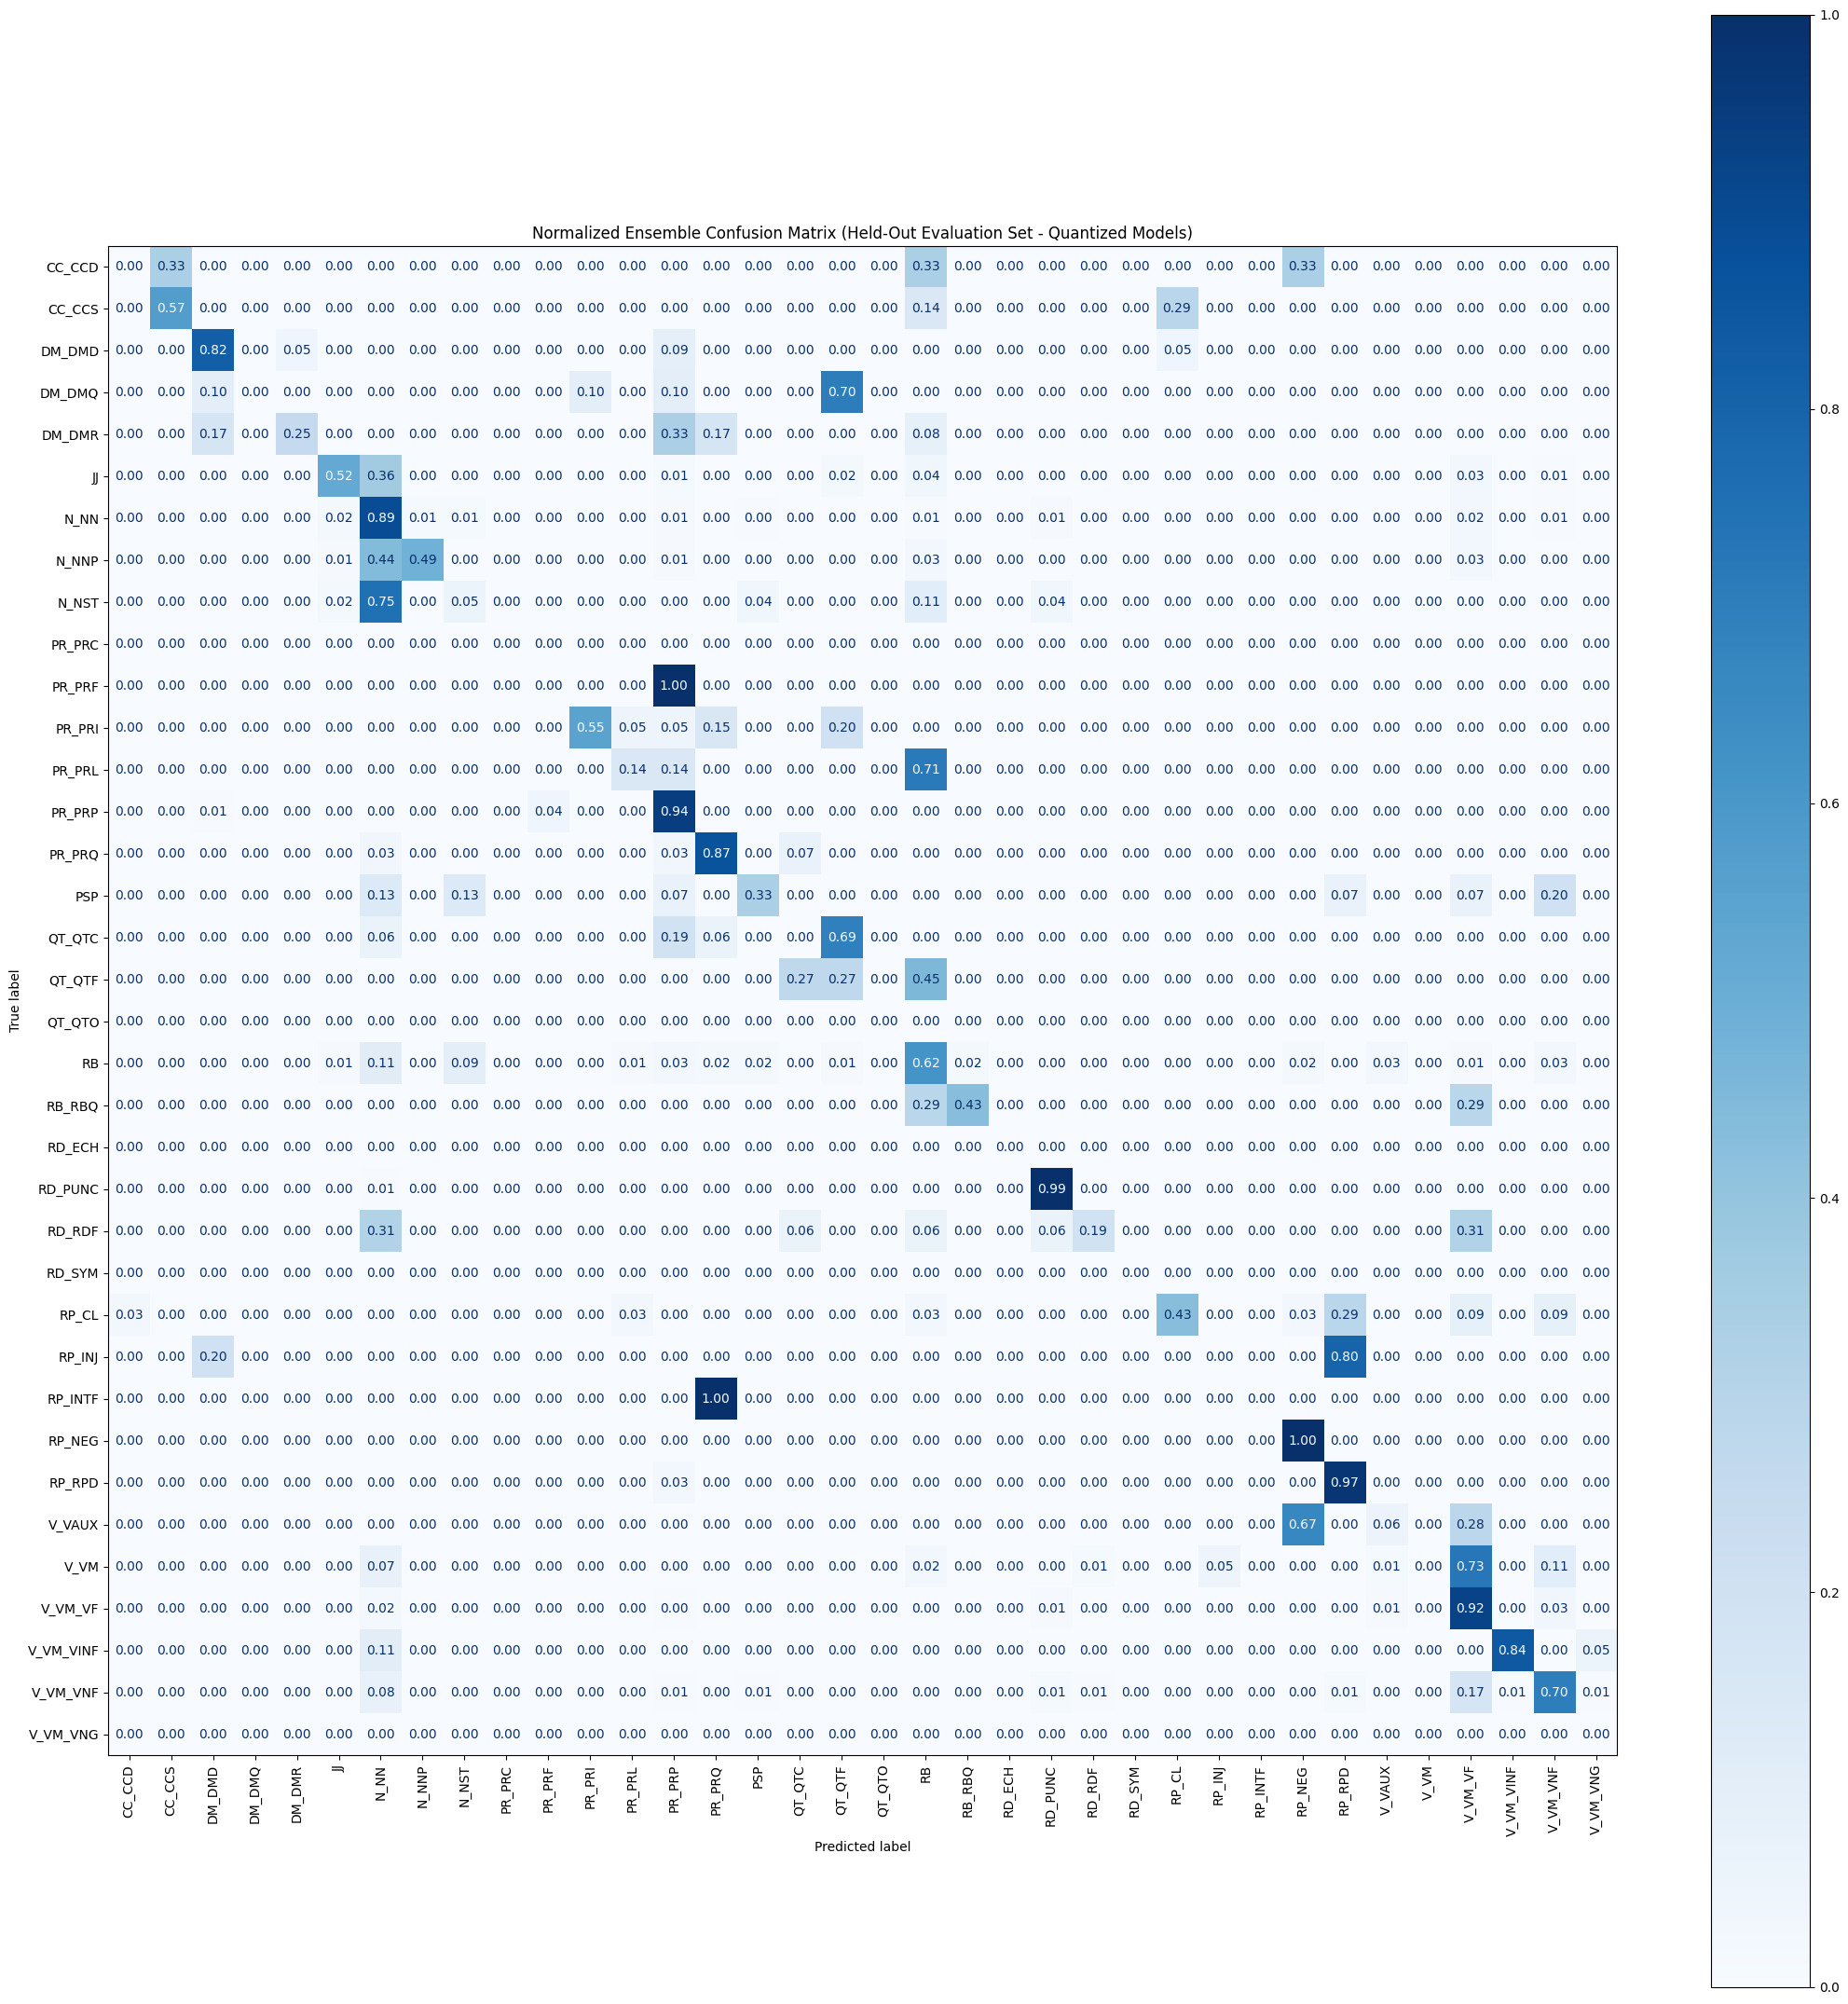


Cleaning up loaded ensemble quantized models after evaluation...


In [74]:
print("\n--- Starting Ensemble Evaluation on Held-Out Evaluation Set (with Quantized Models) ---")

if not best_3_quantized_model_paths:
    print("No best quantized models were selected. Cannot perform ensemble evaluation.")
else:
    ensemble_quantized_models = []
    print(f"Loading {len(best_3_quantized_model_paths)} quantized models for ensembling...")
    try:
        for i, quantized_model_path in enumerate(best_3_quantized_model_paths):
            print(f"  Loading quantized model {i+1}/{len(best_3_quantized_model_paths)} from {quantized_model_path}...")
            model_ensemble = ORTModelForTokenClassification.from_pretrained(quantized_model_path)
            ensemble_quantized_models.append(model_ensemble)
        print("All selected ensemble quantized models loaded successfully for evaluation.")
    except Exception as e:
        print(f"Error loading ensemble quantized models for evaluation: {e}")
        for model in ensemble_quantized_models:
            try: del model
            except: pass
        ensemble_quantized_models = []
        torch.cuda.empty_cache()


    if ensemble_quantized_models:
        def ensemble_predict_dataset_quantized(models, dataset, tokenizer, tag_map, max_length=128):
            """
            Predicts POS tags for a dataset using an ensemble of QUANTIZED ONNX models
            and performs majority voting.
            Returns flattened lists of true and ensembled predicted tags for metrics.
            """
            true_labels_flat = []
            ensemble_predictions_flat = []
            true_label_tags_nested = []
            ensemble_prediction_tags_nested = []

            print(f"Performing ensemble prediction on {len(dataset)} examples using quantized models...")

            for example_idx, example in enumerate(dataset):
                if example_idx % 50 == 0 and example_idx > 0:
                    print(f"  Processed {example_idx}/{len(dataset)} examples...")

                input_ids_np = np.array(example["input_ids"])[None, :]
                attention_mask_np = np.array(example["attention_mask"])[None, :]

                token_type_ids_np = None
                if "token_type_ids" in example and example["token_type_ids"] is not None:
                    token_type_ids_np = np.array(example["token_type_ids"])[None, :]

                true_label_ids = example["labels"]
                word_ids = example["word_ids"]

                all_model_predictions = []

                if not models:
                    print("Error: No ensemble models provided for prediction.")
                    continue

                try:
                    for model_ensemble in models:
                        inputs_to_model = {
                            "input_ids": input_ids_np,
                            "attention_mask": attention_mask_np
                        }
                        if token_type_ids_np is not None:
                            inputs_to_model["token_type_ids"] = token_type_ids_np

                        outputs = model_ensemble(**inputs_to_model)

                        logits = outputs['logits'] if isinstance(outputs, dict) else outputs.logits
                        predictions = np.argmax(logits, axis=-1)
                        predictions = predictions[0]
                        all_model_predictions.append(predictions)

                except Exception as e:
                    print(f"Error during prediction for example {example_idx}: {e}")
                    continue


                sentence_true_tags = []
                sentence_predicted_tags = []

                if all_model_predictions and len(word_ids) == len(true_label_ids) and len(word_ids) == len(all_model_predictions[0]):

                    for token_idx, word_id in enumerate(word_ids):
                        if word_id is not None and token_idx < len(true_label_ids) and true_label_ids[token_idx] != -100:

                            true_tag = tag_map.get(true_label_ids[token_idx], "UNK_LABEL")

                            token_predictions_across_models = [preds[token_idx].item() for preds in all_model_predictions if token_idx < len(preds)]

                            vote_counts = Counter(token_predictions_across_models)
                            if vote_counts:
                                most_common_prediction_id = vote_counts.most_common(1)[0][0]
                            else:
                                most_common_prediction_id = -100

                            ensemble_predicted_tag = tag_map.get(most_common_prediction_id, "UNK_PRED_ID")

                            sentence_true_tags.append(true_tag)
                            sentence_predicted_tags.append(ensemble_predicted_tag)

                            true_labels_flat.append(true_tag)
                            ensemble_predictions_flat.append(ensemble_predicted_tag)
                else:
                    print(f"  Warning: Data length mismatch for example {example_idx}. Skipping ensemble voting for this example.")
                    print(f"  word_ids length: {len(word_ids) if word_ids is not None else 'None'}")
                    print(f"  true_label_ids length: {len(true_label_ids)}")
                    if all_model_predictions:
                        print(f"  all_model_predictions[0] length: {len(all_model_predictions[0])}")
                    else:
                        print("  No model predictions available.")

                if sentence_true_tags:
                    true_label_tags_nested.append(sentence_true_tags)
                    ensemble_prediction_tags_nested.append(sentence_predicted_tags)


            print("Ensemble prediction complete for dataset.")

            ensemble_metrics = {}
            if true_label_tags_nested:
                ensemble_metrics["accuracy"] = seqeval_accuracy_score(true_label_tags_nested, ensemble_prediction_tags_nested)
                ensemble_metrics["precision"] = precision_score(true_label_tags_nested, ensemble_prediction_tags_nested)
                ensemble_metrics["recall"] = recall_score(true_label_tags_nested, ensemble_prediction_tags_nested)
                ensemble_metrics["f1"] = seqeval_f1_score(true_label_tags_nested, ensemble_prediction_tags_nested)
            else:
                print("Warning: No valid labels or predictions found after filtering for ensemble evaluation.")
                ensemble_metrics = {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}

            return true_labels_flat, ensemble_predictions_flat, true_label_tags_nested, ensemble_prediction_tags_nested, ensemble_metrics


        true_labels_eval_flat, ensemble_predictions_eval_flat, true_labels_eval_nested, ensemble_predictions_eval_nested, ensemble_eval_metrics = ensemble_predict_dataset_quantized(
            ensemble_quantized_models,
            tokenized_held_out_evaluation_dataset,
            tokenizer,
            idx2tag
        )

        print("\n--- Ensemble Evaluation Results on Held-Out Evaluation Set (Quantized Models) ---")
        print("Ensemble Metrics:", ensemble_eval_metrics)


        if true_labels_eval_nested:
            print("\nEnsemble Classification Report:")
            all_possible_tags = sorted(list(idx2tag.values()))
            report_labels = [tag for tag in all_possible_tags if tag not in ["UNK_LABEL", "UNK_PRED", "UNK_PRED_ID"]]

            print(seqeval_classification_report(true_labels_eval_nested, ensemble_predictions_eval_nested, zero_division=0))

            print("\nEnsemble Confusion Matrix:")
            cm_labels = sorted(list(set(true_labels_eval_flat) | set(ensemble_predictions_eval_flat)))
            all_matrix_labels = sorted(list(set(all_possible_tags) | set(cm_labels)))

            if not all_matrix_labels:
                all_matrix_labels = sorted(list(idx2tag.values()))


            try:
                cm = confusion_matrix(true_labels_eval_flat, ensemble_predictions_eval_flat, labels=all_matrix_labels, normalize='true')

                fig, ax = plt.subplots(figsize=(max(12, len(all_matrix_labels)*0.6), max(12, len(all_matrix_labels)*0.6)))

                ConfusionMatrixDisplay(
                    confusion_matrix=cm,
                    display_labels=all_matrix_labels
                ).plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax, values_format=".2f")
                plt.title(f"Normalized Ensemble Confusion Matrix (Held-Out Evaluation Set - Quantized Models)")
                plt.tight_layout()
                plt.show()

            except ValueError as e:
                print(f"Could not generate Confusion Matrix (ValueError): {e}.")
                print("Ensure that 'labels' argument in confusion_matrix contains all unique values from true and predicted labels.")
                print(f"Unique True Labels: {set(true_labels_eval_flat)}")
                print(f"Unique Predicted Labels: {set(ensemble_predictions_eval_flat)}")

            except Exception as e:
                print(f"An unexpected error occurred during Confusion Matrix plotting: {e}")
        else:
            print("No data to generate Classification Report or Confusion Matrix.")
    else:
        print("No ensemble quantized models loaded for evaluation.")

    if 'ensemble_quantized_models' in locals() and ensemble_quantized_models:
        print("\nCleaning up loaded ensemble quantized models after evaluation...")
        for model in ensemble_quantized_models:
            try: del model
            except: pass
        ensemble_quantized_models = []
        torch.cuda.empty_cache()

# 10. PREDICTION FUNCTIONS 


In [77]:
def normalize_text(word):
    """Normalizes specific quote characters and zero-width non-joiner."""
    return word.replace('\u2018', "'").replace('\u2019', "'").replace('\u200c', '')

def tokenize_chunk(chunk):
    """Splits a text chunk into potential words and punctuation tokens."""
    punct_pattern = r"([,\.।;!?\u0965]+)$"
    m = re.search(r"(.*?)(" + punct_pattern + r")", chunk)
    if m:
        main_part = m.group(1)
        punctuation = m.group(2)
        tokens = []
        if main_part:
            tokens.extend(tokenize_chunk(main_part))
        tokens.extend(list(punctuation))
        return tokens

    word_internal_chars = "[-–'‘’]"
    bengali_word_chars = r"[\u0980-\u09FF]"
    word_pattern = re.compile(
        rf"^{bengali_word_chars}+(?:{word_internal_chars}{bengali_word_chars}+)*$"
    )
    if word_pattern.match(chunk):
        return [chunk]

    punctuation_set = {"-", "–", "'", "‘", "’", '"', ",", ".", "।", ";", "!", "?", "॥"}
    if chunk in punctuation_set or len(chunk) == 1:
        return [chunk]

    return [chunk]


def extract_bengali_words(text):
    """Splits text by whitespace, then tokenizes each chunk."""
    chunks = text.split()
    tokens = []
    for chunk in chunks:
        normalized_chunk = normalize_text(chunk)
        tokens.extend(tokenize_chunk(normalized_chunk))
    return tokens

def split_text_into_sentences_for_prediction(text):
    """
    Splits raw text into sentences based on Bengali punctuation (।, ॥)
    and potentially empty lines within the text.
    Returns a list of sentence strings.
    """
    sentences = []
    current_sentence_words = []
    sentence_boundary_punct = {"।", "॥"}

    initial_tokens = extract_bengali_words(text)

    if not initial_tokens:
        return []

    for i, token in enumerate(initial_tokens):
        current_sentence_words.append(token)
        if token in sentence_boundary_punct:
            sentence_str = " ".join(current_sentence_words).strip()
            if sentence_str:
                sentences.append(sentence_str)
            current_sentence_words = []

    if current_sentence_words:
        sentence_str = " ".join(current_sentence_words).strip()
        if sentence_str:
            sentences.append(sentence_str)

    return [s for s in sentences if s]


def ensemble_predict_text_quantized(text, models, tokenizer, idx2tag, max_length=128):
    """
    Predicts POS tags for a raw text using an ensemble of QUANTIZED ONNX models
    and performs majority voting.
    Returns aligned words and ensembled predicted tags.
    """
    sentences = split_text_into_sentences_for_prediction(text)
    if not sentences:
        print("No sentences extracted from the input text.")
        return [], []

    all_predicted_words = []
    all_ensembled_tags = []

    for sentence_text in sentences:
        processed_words = extract_bengali_words(sentence_text)
        if not processed_words:
            continue

        normalized_words = [normalize_text(w) for w in processed_words]

        tokenized_input = tokenizer(
            normalized_words,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="np"
        )

        
        input_ids_np = tokenized_input["input_ids"] 
        attention_mask_np = tokenized_input["attention_mask"] 
        token_type_ids_np = tokenized_input.get("token_type_ids")
        if token_type_ids_np is not None:
            token_type_ids_np = token_type_ids_np

        word_ids = tokenized_input.word_ids(batch_index=0)

        all_model_predictions_for_sentence = []

        for model_ensemble in models:
            inputs_to_model = {
                "input_ids": input_ids_np,
                "attention_mask": attention_mask_np
            }
            if token_type_ids_np is not None:
                inputs_to_model["token_type_ids"] = token_type_ids_np

            outputs = model_ensemble(**inputs_to_model)
            logits = outputs['logits'] if isinstance(outputs, dict) else outputs.logits
            predictions = np.argmax(logits, axis=-1)
            all_model_predictions_for_sentence.append(predictions[0])

        ensembled_tags_for_sentence = []
        current_word_index = -1

        for token_idx, word_id in enumerate(word_ids):
            if word_id is not None and word_id != current_word_index:
                current_word_index = word_id

                token_predictions_across_models = [
                    preds[token_idx].item() for preds in all_model_predictions_for_sentence
                    if token_idx < len(preds)
                ]

                vote_counts = Counter(token_predictions_across_models)
                if vote_counts:
                    most_common_prediction_id = vote_counts.most_common(1)[0][0]
                else:
                    most_common_prediction_id = -100

                ensembled_predicted_tag = idx2tag.get(most_common_prediction_id, "UNK_PRED_ID")
                ensembled_tags_for_sentence.append(ensembled_predicted_tag)

        all_predicted_words.extend(processed_words)
        all_ensembled_tags.extend(ensembled_tags_for_sentence)

    return all_predicted_words, all_ensembled_tags

# 11. ENSEMBLE PREDICTION DEMONSTRATION

In [78]:

model_path_for_prediction = ensemble_model_save_dir

print(f"\n--- Loading Best 3 Quantized Models for Ensemble Prediction from '{model_path_for_prediction}' ---")
ensemble_models_for_prediction = []
if not best_3_quantized_model_paths:
    print("No best 3 quantized models available for prediction demonstration.")
else:
    try:
        for i, quantized_model_path in enumerate(best_3_quantized_model_paths):
            print(f"  Loading quantized model {i+1}/{len(best_3_quantized_model_paths)} from {quantized_model_path}...")
            model_ensemble = ORTModelForTokenClassification.from_pretrained(quantized_model_path)
            ensemble_models_for_prediction.append(model_ensemble)
        print("All selected ensemble quantized models loaded successfully for prediction.")
    except Exception as e:
        print(f"Error loading ensemble quantized models for prediction: {e}")
        for model in ensemble_models_for_prediction:
            try: del model
            except: pass
        ensemble_models_for_prediction = []
        torch.cuda.empty_cache()


if ensemble_models_for_prediction:
    sample_text = """
আমার মাথা নত করে দাও হে তোমার চরণধুলার তলে।
সকল অহংকার হে আমার
ডুবায়ে দাও চোখের জলে॥
নিজেরে করিতে গৌরব দান
নিজেরে কেবলই করি অপমান।
আপনারে শুধু ঘেরিয়া ঘেরিয়া
ঘুরিয়া মরি পলে পলে॥
"""

    print(f"\n--- Predicting POS tags for sample text using Ensemble of Best 3 Quantized Models ---")
    print(f"Sample Text: {sample_text}")

    predicted_words_ensemble, predicted_tags_ensemble = ensemble_predict_text_quantized(
        sample_text, ensemble_models_for_prediction, tokenizer, idx2tag
    )

    print("\nEnsemble Prediction Results:")
    if len(predicted_words_ensemble) == len(predicted_tags_ensemble):
        for w, t in zip(predicted_words_ensemble, predicted_tags_ensemble):
            print(f"{w}: {t}")
    else:
        print("Warning: Mismatch between number of words and predicted tags in ensemble prediction.")
        print("Words:", predicted_words_ensemble)
        print("Predicted Tags:", predicted_tags_ensemble)

    print("\nCleaning up loaded ensemble quantized models after prediction demonstration...")
    for model in ensemble_models_for_prediction:
        try: del model
        except: pass
    ensemble_models_for_prediction = []
    torch.cuda.empty_cache()

else:
    print("Skipping ensemble prediction demonstration as no models were loaded.")


--- Loading Best 3 Quantized Models for Ensemble Prediction from './ensemble_models_tuned_non_peft_quantized' ---
  Loading quantized model 1/8 from ./ensemble_models_tuned_non_peft_quantized/fold_1/quantized_model...
  Loading quantized model 2/8 from ./ensemble_models_tuned_non_peft_quantized/fold_4/quantized_model...
  Loading quantized model 3/8 from ./ensemble_models_tuned_non_peft_quantized/fold_7/quantized_model...
  Loading quantized model 4/8 from ./ensemble_models_tuned_non_peft_quantized/fold_5/quantized_model...
  Loading quantized model 5/8 from ./ensemble_models_tuned_non_peft_quantized/fold_3/quantized_model...
  Loading quantized model 6/8 from ./ensemble_models_tuned_non_peft_quantized/fold_9/quantized_model...
  Loading quantized model 7/8 from ./ensemble_models_tuned_non_peft_quantized/fold_2/quantized_model...
  Loading quantized model 8/8 from ./ensemble_models_tuned_non_peft_quantized/fold_6/quantized_model...
All selected ensemble quantized models loaded success

# ZIPPING THE BEST MODELS


In [79]:
print("\n--- Zipping selected best models for future use ---")

zip_filename = os.path.join("./", "best_ensemble_quantized_models.zip")

try:
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for model_path in best_3_quantized_model_paths:
            for root, dirs, files in os.walk(model_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, ensemble_model_save_dir)
                    zipf.write(file_path, arcname)

        id2label_path = os.path.join(ensemble_model_save_dir, "id2label.json")
        label2id_path = os.path.join(ensemble_model_save_dir, "label2id.json")

        if os.path.exists(id2label_path):
            zipf.write(id2label_path, os.path.relpath(id2label_path, ensemble_model_save_dir))
        if os.path.exists(label2id_path):
            zipf.write(label2id_path, os.path.relpath(label2id_path, ensemble_model_save_dir))

    print(f"\nSuccessfully zipped the best models and tag maps to {zip_filename}")

except Exception as e:
    print(f"\nError zipping models: {e}")




--- Zipping selected best models for future use ---

Successfully zipped the best models and tag maps to ./best_ensemble_quantized_models.zip
